In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from scipy.optimize import basinhopping
import sys
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing

In [ ]:
def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(63001)
    for i in range(251):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]

    return long_beta

def expand_array(short_array):
    long_array = np.zeros(63001)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(251) * (251 + 1)] = short_array
    return long_array




def compress_array(long_array):
    return long_array[np.arange(251) * (251 + 1)]  # Extract values from the expanded positions



# Load dictionary
with open("Proper_London_Patch_Populations_1_5km_fixed.pkl", "rb") as file:
    pop_dict = pickle.load(file)

# Extract values in order
short_pop_vector = np.array(list(pop_dict.values()))

pop_vector = expand_array(short_pop_vector)

with open("London Borough List.pkl", 'rb') as f:
    borough_list = pickle.load(f)

with open("London Station List.pkl", "rb") as file:
    station_list = pickle.load(file)

with open("London Station Borough List.pkl", 'rb') as f:
    station_borough_list = pickle.load(f)

with open("Proper London Station Borough Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)

covid_df = pd.read_csv("phe_cases_london_boroughs_fixed.csv")

borough_populations = pd.read_csv("london population 1801 to 2021_cleaned.csv")

# Define main control panel functions

# with open("London new Nj.pkl", "rb") as file:
    # Nj = pickle.load(file)

with open("London Home Patch Indices.pkl", "rb") as file:
    home_patches = pickle.load(file)

# Load files
with open("Sparse London P Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()
Nj = pop_vector @ p_matrix

with open("London Unique Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)

with open("London Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

# with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    # commuter_array = pickle.load(file)
################################################################################################
################################################################################################
################################################################################################
################################################################################################

def get_timeseries(station_name,covid_df,props_dict):

    current_borough = props_dict[station_name][0]

    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-03-22") &
        (covid_df['area_name'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-03-07"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) &
        (filtered_df['date'] <= "2020-03-07")
    ]

    borough_timeseries = np.array(list(filtered_df['total_cases']))

    station_timeseries = props_dict[station_name][1]*borough_timeseries




    return station_timeseries



def get_timeseries_with_five(station_name, covid_df, props_dict):
    current_borough = props_dict[station_name][0]

    # Define the start and end dates
    end_date = "2020-06-22"
    earliest_nonzero_date = "2020-03-07"
    five_days_before = "2020-03-04"  # 5 days before the earliest nonzero date

    # Filter data for the given borough within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] >= earliest_nonzero_date) &
        (covid_df['date'] <= end_date) &
        (covid_df['area_name'] == current_borough)
    ]

    borough_timeseries = np.array(filtered_df['total_cases'])
    station_timeseries = props_dict[station_name][1] * borough_timeseries

    # Get new cases in the 5 days before the earliest nonzero date
    previous_df = covid_df[
        (covid_df['date'] >= five_days_before) &
        (covid_df['date'] < earliest_nonzero_date) &
        (covid_df['area_name'] == current_borough)
    ]

    total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['new_cases'].sum()

    return station_timeseries, total_new_cases_prev_5_days


################################################################################################
################################################################################################
################################################################################################
################################################################################################


all_station_timeseries = []
all_new_cases_prev_5_days = []
for i in range(len(station_list)):
    timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
    all_station_timeseries.append(timeseries[0])
    all_new_cases_prev_5_days.append(timeseries[1])


all_station_timeseries = np.array(all_station_timeseries)
day_range = all_station_timeseries[0].shape[0]

def compress_timeseries(long_timeseries,timesteps=day_range):
    compressed = np.zeros((timesteps, 251))  # Adjusted to match the original short array shape

    for i in range(timesteps):
        compressed[i] = compress_array(long_timeseries[i])

    return compressed.T  # Transpose back to match original input shape

print(day_range)

def expand_array(short_array):
    long_array = np.zeros(63001)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(251) * (251 + 1)] = short_array
    return long_array


def expand_timeseries(short_timeseries,timespan=day_range):

    transposed = short_timeseries.T

    long_timeseries = np.zeros((timespan,63001))
    for i in range(timespan):
        long_timeseries[i] = expand_array(transposed[i])

    long_timeseries = np.array(long_timeseries)

    return long_timeseries

working_timeseries = expand_timeseries(all_station_timeseries,day_range)
short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = expand_array(short_pop_vector)
day_list = np.arange(day_range)
data = np.column_stack((day_list[:, None], working_timeseries))


current_cases = np.array(all_new_cases_prev_5_days)
cum_cases = data[0][1:]


np.set_printoptions(suppress=True)


pairs_list = []
for i in range(len(station_list)):
    for j in range(len(station_list)):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)

with open("Sparse London Expanded P Matrix.pkl", "rb") as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()

108


In [ ]:
with open("Distributed Updated Formalized London Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)

home_betas = best_beta_yet_0[:251]
home_betas.shape

(251,)

In [ ]:
N = pop_vector.copy()
gamma = 1/5

def calc_F_for_idx(i):
    F = 0

    for k in range(251):
        p_k = home_patches[k]
        denom = 0
        for l in range(251):
            p_l = home_patches[l]
            denom += p_matrix[p_l][p_k]
        F += home_betas[k]*p_matrix[i][p_k]*p_matrix[i][p_k]/denom

    return F

calc_F_for_idx(0)

np.float64(0.23407856670405555)

In [ ]:
num_infected_16_days = solution[1][home_patches].T[15].T
num_infected_16_days.shape

(251,)

In [ ]:
patch_R0s = []
for i in range(251):
    patch_R0s.append(calc_F_for_idx(home_patches[i])/gamma)
patch_R0s = np.array(patch_R0s)
patch_R0s

array([1.17039283, 1.33861279, 0.9088621 , 1.62467117, 1.03450849,
       1.27773496, 1.14123533, 1.53220884, 0.83490154, 1.29015176,
       0.56609841, 1.20759135, 1.07461158, 1.4103161 , 1.2522853 ,
       1.44628446, 1.42075226, 1.37175937, 1.50058778, 0.84844916,
       1.15462716, 1.17893164, 1.05923372, 1.63317661, 1.37279709,
       1.43289253, 1.03000892, 1.4077901 , 1.42590131, 1.1756708 ,
       1.30938556, 1.39036987, 1.01488396, 1.45685928, 0.43249607,
       1.162806  , 1.40823558, 1.70750319, 1.39271339, 1.05154734,
       1.02656781, 1.45014613, 1.37119958, 1.7223796 , 1.76799818,
       1.46985023, 1.33369297, 1.26230182, 1.4996377 , 1.20423367,
       1.24650814, 1.44103653, 1.32201129, 1.6759768 , 0.79083738,
       1.29014215, 1.00023529, 1.37281524, 1.19930165, 1.17635941,
       1.5385135 , 1.07271939, 1.28946235, 1.47565694, 1.37100457,
       1.33071405, 1.14188028, 1.05946543, 0.74508061, 1.07692495,
       1.42233156, 0.85672489, 1.25491555, 1.22838455, 0.88544

In [ ]:
# 100 MOST POPULOUS
num_indices = 100

indices = np.argpartition(short_pop_vector, -num_indices)[-num_indices:]
indices = indices[np.argsort(short_pop_vector[indices])[::-1]]
indices

array([ 59, 221, 225,  28, 181,  19,  34, 217, 124,  12,  18, 153, 129,
       106,  45,  97,  91, 164, 210, 193, 140,   5, 109,  33, 125,  60,
        35,   4,  25, 201,  76,  43, 243,  52, 244, 248,  47, 137,  94,
       147, 202,  58,  21, 220, 159, 133,  95,  16,  74, 155,   9, 204,
       104, 209,   7, 168,  62,  48,  30, 240,  26, 139, 162, 194, 246,
         6, 174,  98,  75, 212, 114,  72, 167, 110,  66,  54,  53,  17,
        27, 249, 146,  57,  44,  31,  78, 215, 192, 113, 171, 187, 184,
       247, 231, 188,  29, 105, 115, 117, 236, 216])

In [ ]:
# 100 MOST INFECTIOUS

num_indices = 100

indices = np.argpartition(num_infected_16_days, -num_indices)[-num_indices:]
indices = indices[np.argsort(num_infected_16_days[indices])[::-1]]
indices

array([ 28,  18, 109,  33,  59, 181,  45, 210,  19, 221, 225, 193,  34,
       129,  60, 217,  43, 153,  97, 137, 202, 240, 155,   5, 159, 162,
         9,  48,  91, 184, 209,   4, 188, 246, 106, 124, 244,  25,  75,
        74, 248,  47,  94,  44, 243, 201,  58,  12, 164,  95, 247, 147,
         7,  57, 119, 168, 133,  17,  62, 139,  30, 125,  35,  23, 140,
        65,  77, 114,  56, 167,  26,  98, 110, 104, 212,  72,  53, 236,
        31,  14, 215, 166, 194,  54, 238,  27, 174,   6,  21, 191,  78,
       204, 111,  76,  96, 231, 128, 146, 115,  52])

In [ ]:
# 100 BIGGEST Betas

num_indices = 100

indices = np.argpartition(home_betas, -num_indices)[-num_indices:]
indices = indices[np.argsort(home_betas[indices])[::-1]]
indices

array([ 91, 187, 127, 171, 144,  37, 237, 163, 200, 195, 223,  28,  92,
        65, 168, 139, 244, 110,  53, 229, 167, 115, 202, 114, 117,  90,
       203, 145,  43, 155, 112, 206, 231, 230, 120,  44, 189,   3, 165,
       245, 193,  60,  45, 209, 210,  33,  18, 148,   9,  23, 109, 129,
       118, 188, 224, 157, 246,   8, 137, 196, 131,  39,  48, 132,  22,
        11,  82,  49, 211, 191,   7,  56, 126, 156, 169, 247, 107, 121,
        83, 123, 161, 208,   1, 130, 136,  20, 241,  64, 198, 215,  40,
        36,  67,  10, 173, 162, 151,   5, 197,  97])

In [ ]:
# Get betas > 0.5

# Get indices where beta > 0.6
indices = np.where(home_betas > 0.575)[0]

# Sort indices by descending beta values
indices = indices[np.argsort(home_betas[indices])[::-1]]

# Result
print(indices,"\n\n",indices.size,"in total")


[188 118  56 151  18  33 109  28  96 129 184  65  23 162  77 210  43  45
 240 193 202 155  60   9 197 209  44 132 228 128 127 195 137 176  63  15
  11 246  48  64 224   8 131  82 173 121 120 157 247 196 223  39 191  22
  17  49 159 107 236  75 111 169 153  38 211  97   1 126 208 156  91 138
 130 244  83 123  88  20 161 116 207 181   5 136 241  57 182   4  14  32
  87  40 198 168  36 166  67 119 139 114 233  10 167  74 238 217 231 110
  53 117  73 115   7 171 230  90 180 187 183 203   3  79 199 242  37 215
  31 163 112  25 200 248 145 206 245 144 165 170 229 101 237  92 102 189
  98 212] 

 146 in total


In [ ]:
# 100 BIGGEST R0s

num_indices = 100

indices = np.argpartition(patch_R0s, -num_indices)[-num_indices:]
indices = indices[np.argsort(patch_R0s[indices])[::-1]]
indices

array([237, 120, 144, 155,  44, 187, 189,  43, 110,  37, 145, 202, 206,
       163,  53, 115, 112, 139, 203,  90, 109,  23, 165,   3, 200, 171,
       247, 168, 117, 245,  60, 193, 191,  91,   7, 173, 176, 167, 148,
        18,  48, 230, 209, 128, 175, 142, 107,  63, 215, 240,  45,  98,
       220, 223,  33, 228, 134,  79,  41,  81,  15,  51, 234, 137, 114,
       138, 232,  25,  28,  88, 195,  70, 121,  16, 199, 170,  13,  36,
        27, 183, 169, 244, 213, 235,  38,  31, 130, 250, 205, 160, 158,
        57,  24,  17,  42,  64, 172, 217, 185, 226])

In [ ]:
# 100 SMALLEST R0s

num_indices = 50

indices = np.argpartition(patch_R0s, num_indices)[:num_indices]
indices = indices[np.argsort(patch_R0s[indices])]
indices

array([156, 224,  34, 126, 116,  10, 127, 129, 157, 222,  83,  87, 214,
       161,  54, 229, 204, 123, 211,  68, 100, 136,   8,  71,  74, 133,
       174,  19, 216, 241, 188,  85, 243, 153, 182,   2,  93,  12, 218,
        40, 105, 227, 231,   4, 198,  61,  67, 225,  39, 149])

In [ ]:
cvr = np.array([  0.37541681,   1.89941788,   0.43646397,   0.18299401,
         0.29606019,   0.22222949,   0.77549501,   0.1924569 ,
         1.12079838,   0.47066279, 101.42523556,   0.53326196,
         0.27610548,   0.26246447,   0.26773801,   0.33101228,
         0.22877043,   0.27117427,   0.41103049,   0.28631812,
         3.10474716,   0.32225747,   1.16821027,   0.43416594,
         0.32493835,   0.25863683,   0.28738821,   0.22180516,
         0.41213962,   0.25460087,   0.23263136,   0.23132471,
         0.48013688,   0.42573476,   0.51868428,   0.27487277,
         7.51145869,   0.2801635 ,   0.28122034,   1.06929372,
         7.43710391,   0.25799322,   0.34229115,   0.39098785,
         0.39495872,   0.40733198,   0.75666778,   0.23894593,
         0.32687471,   1.15816353,   0.35292542,   0.23653997,
         0.24417536,   0.17342009,   0.49589756,   0.43496231,
         0.45725491,   0.22074866,   0.26190731,   0.23022554,
         0.39527212,   0.43916323,   0.23453229,   0.2884342 ,
         0.42995271,   0.56747547,   0.7018135 ,  14.58638007,
         1.40788765,   1.7646171 ,   0.26525477,   1.18643024,
         0.25955052,   0.41916122,   0.37725203,   0.26941467,
         0.28058   ,   0.35711469,   0.29508569,   0.21432935,
         0.58591868,   0.24510595,   0.61211062,   5.13772285,
         0.36053348,   0.61270868,   0.30385653,   0.72324628,
         0.28065351,   0.40222304,   0.17514682,   0.25860312,
         0.45336183,   0.53135527,   0.24881079,   0.21906477,
         0.40064011,   0.26990654,   0.26139814,   0.40403608,
         2.15179697,   0.29055797,   0.26012783,   0.74656132,
         0.42110407,   0.4774294 ,   0.3788    ,   0.95995093,
         0.48181676,   0.39775384,   0.16464064,   0.30142119,
         0.1691262 ,   0.74764878,   0.21051422,   0.17926494,
         1.15159264,   0.19132311,   0.74902003,   0.28191619,
         0.41160025,   0.54742906,   0.26729077,   4.67893364,
         0.31857483,   0.32183182,   6.49594353,   1.70158738,
         0.24235552,   1.45833691,   2.21473735,   0.73530505,
         0.44202318,   0.35307219,   0.22357834,   0.54200311,
         5.80023289,   0.3311054 ,   0.28592217,   0.17259992,
         0.25842569,   0.47544299,   0.344979  ,   2.40738876,
         0.27967666,   0.16683561,   0.33228548,   0.31982028,
         0.42879166,   0.44318859,   0.38071774,   0.45261782,
         0.82099457,   0.29825353,   0.43814362,   0.38871217,
         8.96916477,   1.66055929,   0.50866808,   0.23188055,
         0.31836466,   5.33218973,   0.28767723,   0.28988031,
         0.23413873,   0.20698106,   0.24918876,   0.19399675,
         0.17561262,   1.20990281,   0.24144497,   0.29428005,
         0.28982727,   0.42831587,   0.82121708,   0.23588575,
         0.23939167,   0.4885638 ,   0.41198124,   0.46373998,
         0.47453923,   0.27399576,   0.46014388,   0.23262561,
         0.35474281,   0.3122789 ,   0.34046446,   0.27177438,
         0.49221082,   0.16785374,   0.40401141,   0.33606053,
         0.29137617,   0.38898849,   0.78977993,   0.87557171,
         0.94281586,   0.31513756,   8.83226263,   0.2244314 ,
         0.30539424,   0.25476556,   0.40110268,   0.17468109,
         0.48232089,   0.31053469,   0.17563565,   0.32493742,
         2.14228917,   0.42076725,   0.44654552,   2.95671893,
         0.30987717,   0.22369839,   1.48032211,   0.20845441,
         0.55389312,   0.26456275,   0.89804857,   0.7211277 ,
         0.22186481,   0.22869303,   0.60650914,   0.59688808,
         2.07927434,   0.30374721,   0.31144397,   1.12326418,
         0.26470331,   4.26087196,   0.199529  ,   0.27301231,
         0.33158823,   0.29508144,   0.22233369,   0.25705668,
         0.32130981,   0.27669012,   0.24205025,   0.43301377,
         0.22253344,   5.53590988,   0.42247472,   0.32404708,
         0.20065359,   0.21505195,   0.37562552,   0.30455127,
         0.29406257,   0.2959332 ,   0.23113936])

# 100 SMALLEST R0s

num_indices = 50

indices = np.argpartition(cvr, -num_indices)[-num_indices:]
indices = indices[np.argsort(cvr[indices])[::-1]]
indices

array([ 10,  67, 156, 198,  36,  40, 126, 136, 241, 161,  83, 123, 229,
        20, 211, 143, 130, 100, 208, 224,   1,  69, 127, 157, 214, 129,
        68, 169,  71,  22,  49, 116, 227,   8,  39, 107, 196, 218, 195,
       174, 152, 194,   6,  46, 118, 113, 103, 131,  87, 219])

In [ ]:
np.array(station_list)[indices]

array(['Bank & Monument', 'Embankment', 'Oxford Circus', "St. Paul's",
       'Cannon Street', 'Charing Cross', 'Liverpool Street', 'Moorgate',
       'Westminster', 'Piccadilly Circus', 'Green Park',
       'Leicester Square', 'Waterloo', 'Blackfriars',
       'Tottenham Court Road', 'North Greenwich', 'Mansion House',
       'Holborn', 'Temple', 'Victoria', 'Aldgate', 'Euston Square',
       'London Bridge', 'Paddington', 'Tower Hill', 'Manor House',
       'Euston', 'Queensway', 'Farringdon', 'Bond Street',
       'Covent Garden', "King's Cross St. Pancras", 'Warren Street',
       'Baker Street', 'Chancery Lane', 'Hyde Park Corner',
       "St. James's Park", 'Upminster', 'Southwark', 'Richmond',
       'Oakwood', 'Southgate', 'Arnos Grove', 'Cockfosters',
       'Knightsbridge', 'Kew Gardens', 'Hornchurch', 'Marble Arch',
       'Hammersmith', 'Upminster Bridge'], dtype='<U24')

In [ ]:
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:63001]
    I_sol = solution[63001:126002]
    I_sol_total = solution[126002:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London(params):
    S0,I0,I_total0,beta,gamma,timesteps = params

    if beta.shape[0]==837:
        beta = expand_betas(beta,63001)


    # Ensure no dividing by zero
    Nj[Nj == 0] = 1

    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))

    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix
    beta_p_matrix = sparse_p.multiply(beta[:, None])

    t = np.linspace(0,timesteps-1,num=timesteps)



    def sir(y,timestep):
        S = y[:63001]
        I = y[63001:126002]
        I_total = y[126002:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = p_matrix.T @ I


        method = "vector"

        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (63001,)

            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (63001, 63001)
            infection_terms = infection_terms @ Ij_div_Nj  # (63001,)

            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms


        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt

        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx

    y_log = np.zeros((len(t)+1,189003))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        # print("step:",step)
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results

    solution = process_solution(y_log.T,timesteps)

    return solution


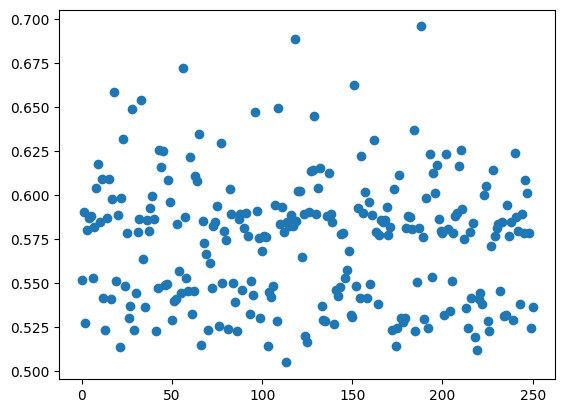

In [ ]:
plt.scatter(range(251),home_betas)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

def make_detailed_beta(short_beta):
    new_beta_0 = np.zeros(837)

    for i in range(251):
        new_beta_0[i] = short_beta[i]
    for i in range(837-251):
        new_beta_0[i+251] = short_beta[-1]
    return np.array(new_beta_0)

def expand_detailed_beta(detailed_beta):
    big_beta = np.zeros(63001)
    home_betas = detailed_beta[:251]
    travel_betas = detailed_beta[251:]
    big_beta[home_patches] = home_betas
    big_beta[travel_patches] = travel_betas

    return big_beta

# Load best beta values
with open("Distributed Updated Formalized London Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)

def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(63001)
    for i in range(251):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]

    return long_beta

best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

def plot_best_beta_vs_data(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet,
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries,day_range)

    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)

    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)

    I0 = np.zeros(63001)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases

    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T,day_range)
    raw_real_data = compress_timeseries(data.T[1:].T,day_range)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]


    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()

    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()

    return np.array(solution),params

solution,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

In [ ]:
# Get top 50

reshaped_sol = solution[1][home_patches]

# Compute the ratio of final values to corresponding short_pop_vector entries
ratios = reshaped_sol[:, -1] / short_pop_vector

# Get indices of the 50 rows with the highest ratios
top_50_indices = np.argsort(ratios)[-100:][::-1]

top_50_indices

array([188, 184,  18, 109,  56,  77,  96, 151,  33, 119, 233, 240,  28,
       101, 118, 122,  23, 162, 128, 176,  43, 155, 228, 202, 137,  65,
        48,  44, 197, 210,  63, 247, 246,  45, 193,  60,   9, 191,  15,
       209, 159, 132, 120,  57,  75,  64, 223, 173, 195,  11, 238, 166,
        79,  14, 183, 127, 121, 199,  82, 131, 129, 170,   8, 196, 224,
        39, 157, 182,  22, 229, 107,  49, 169,  17,  87, 242, 211,   1,
       208, 130,  20, 126, 123,  83, 156, 161, 241, 136,  40, 236, 198,
        36, 111,  67,  38,  10, 138,  88, 207,  32])

In [ ]:
np.array(station_list)[top_50_indices]

array(['South Kensington', 'Sloane Square', 'Bermondsey', 'Kennington',
       "Earl's Court", 'Gloucester Road', 'High Street Kensington',
       'Notting Hill Gate', 'Canada Water', 'Ladbroke Grove',
       'West Brompton', 'Westbourne Park', 'Brixton', 'Holland Park',
       'Knightsbridge', 'Latimer Road', 'Borough', 'Pimlico',
       'Maida Vale', 'Royal Oak', 'Clapham Common', 'Oval',
       'Warwick Avenue', 'Stockwell', 'Morden', 'Elephant & Castle',
       'Colliers Wood', 'Clapham North', "St. John's Wood",
       'Tooting Broadway', 'Edgware Road (B)', 'Wimbledon Park',
       'Wimbledon', 'Clapham South', 'Southfields', 'East Putney',
       'Balham', 'South Wimbledon', 'Bayswater', 'Tooting Bec',
       'Parsons Green', 'Marylebone', 'Lambeth North', 'East Acton',
       'Fulham Broadway', 'Edgware Road (C)', 'Vauxhall', "Regent's Park",
       'Southwark', 'Barbican', 'West Kensington', 'Putney Bridge',
       'Goldhawk Road', 'Barons Court', "Shepherd's Bush Market",
   

In [ ]:

def sparse_isolate_patch(sparse_expanded_p_matrix, patch_idx, modification):
    from scipy.sparse import lil_matrix

    new_p = sparse_expanded_p_matrix.copy().tolil()  # stay sparse throughout
    changing_rows, home_indices = get_associated_indices(patch_idx)

    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        # Scale all nonzero entries
        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        # Find the sum after scaling
        row_total = sum(row_data[1])

        # Find the original total (before scaling)
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        # Correct the home index
        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            # If home wasn't in original nonzeros, add it
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()

def get_associated_indices(station_idx):
    station_name = station_list[station_idx]
    associated_indices = []
    associated_homes = []
    mode = "everyone"
    # mode = "workers only"

    for i in range(63001):
        if station_name in pairs_list[i]:
            home_idx = home_patches[station_list.index(pairs_list[i][0])]
            if mode == "workers only":
                if home_patches[station_idx] != home_idx:
                    associated_indices.append(i)
                    associated_homes.append(home_idx)
            else:
                associated_indices.append(i)
                associated_homes.append(home_idx)
    return associated_indices,associated_homes

def isolate_patch(expanded_p_matrix,patch_idx,modification):
    new_p = expanded_p_matrix.copy()
    important_indices = get_associated_indices(patch_idx)
    changing_rows = important_indices[0]
    home_indices = important_indices[1]
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_total = np.sum(new_p[row])
        new_p[row] *= 1-modification
        new_p[row][home] += row_total - np.sum(new_p[row])

    return np.round(new_p,1)

def convert_back_to_classic_p(fourth_phase):
    fifth_phase = np.zeros((63001,63001))

    for i in range(63001):
        connection = connections_list[i]
        home_patch = connection[0]
        home_index = connections_list.index((home_patch,home_patch))
        fifth_phase[home_index] += fourth_phase[i]

    sixth_phase = np.zeros((63001,63001))

    for i in range(63001):
        if np.sum(fifth_phase[i]) != 0:
            sixth_phase[i] = fifth_phase[i]/np.sum(fifth_phase[i])
        else:
            sixth_phase[i][i] = 1

    return sixth_phase


def full_sparse_isolate(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i in range(63001):
        pair = pairs_list[i]
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = ([], [])
            station_to_indices_homes[station][0].append(i)
            station_to_indices_homes[station][1].append(home_patches[station_list.index(pair[0])])

    # Build total set of affected rows and homes
    changing_rows = []
    home_indices = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        associated = station_to_indices_homes.get(station_name, ([], []))
        changing_rows.extend(associated[0])
        home_indices.extend(associated[1])

    # Now apply all changes
    new_p = sparse_expanded_p_matrix.copy().tolil()
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        row_total = sum(row_data[1])
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()

def full_sparse_isolate_fast(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i, pair in enumerate(pairs_list[:63001]):
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = []
            station_to_indices_homes[station].append((i, home_patches[station_list.index(pair[0])]))

    # Collect affected rows and homes
    changing_info = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        changing_info.extend(station_to_indices_homes.get(station_name, []))

    if not changing_info:
        return sparse_expanded_p_matrix.copy()

    # Convert once
    new_p = sparse_expanded_p_matrix.tolil()

    # Apply changes
    for row, home in changing_info:
        cols = new_p.rows[row]
        data = new_p.data[row]

        if not data:
            continue

        original_total = sum(data)
        for i in range(len(data)):
            data[i] *= (1 - modification)

        reduced_total = sum(data)
        correction = original_total - reduced_total

        try:
            idx_home = cols.index(home)
            data[idx_home] += correction
        except ValueError:
            cols.append(home)
            data.append(correction)

    return new_p.tocsr()


import numpy as np
from scipy.sparse import csr_matrix

# --- Precompute everything outside the function ---

# Assume station_list, pairs_list, home_patches already defined
station_idx_map = {station: idx for idx, station in enumerate(station_list)}
home_patches = np.array(home_patches)

station_to_rows = {}
row_home_patches = np.empty(len(pairs_list[:63001]), dtype=int)

for i, pair in enumerate(pairs_list[:63001]):
    home = home_patches[station_idx_map[pair[0]]]
    row_home_patches[i] = home
    for station in pair:
        station_to_rows.setdefault(station, []).append(i)

# (Optional) Preconvert patch indices to station names
def get_patch_station_names(patch_indices, station_list):
    return [station_list[idx] for idx in patch_indices]

def full_sparse_isolate_ultrafast_csr(sparse_expanded_p_matrix, patch_station_names, station_to_rows, row_home_patches, modification=0.9):
    affected_rows = set()
    for station_name in patch_station_names:
        affected_rows.update(station_to_rows.get(station_name, []))

    if not affected_rows:
        return sparse_expanded_p_matrix.copy()

    affected_rows = np.array(list(affected_rows), dtype=int)

    p_csr = sparse_expanded_p_matrix.copy().tocsr()

    for row in affected_rows:
        start, end = p_csr.indptr[row], p_csr.indptr[row+1]
        if start == end:
            continue

        cols = p_csr.indices[start:end]
        data = p_csr.data[start:end]

        original_total = np.sum(data)
        data *= (1 - modification)
        reduced_total = np.sum(data)
        correction = original_total - reduced_total

        home = row_home_patches[row]
        home_idx = np.where(cols == home)[0]

        if home_idx.size > 0:
            data[home_idx[0]] += correction
        else:
            p_csr = insert_into_csr(p_csr, row, home, correction)

    return p_csr

def insert_into_csr(csr, row, col, value):
    new_indices = np.insert(csr.indices[csr.indptr[row]:csr.indptr[row+1]], 0, col)
    new_data = np.insert(csr.data[csr.indptr[row]:csr.indptr[row+1]], 0, value)

    sorted_idx = np.argsort(new_indices)
    new_indices = new_indices[sorted_idx]
    new_data = new_data[sorted_idx]

    csr.indices = np.concatenate([
        csr.indices[:csr.indptr[row]],
        new_indices,
        csr.indices[csr.indptr[row]:]
    ])
    csr.data = np.concatenate([
        csr.data[:csr.indptr[row]],
        new_data,
        csr.data[csr.indptr[row]:]
    ])
    csr.indptr[row+1:] += 1

    return csr




In [ ]:
# PIECEWISE FUNCTION
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:63001]
    I_sol = solution[63001:126002]
    I_sol_total = solution[126002:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London_with_isolation(params):
    S0,I0,I_total0,beta,gamma,timesteps = params

    if beta.shape[0]==837:
        beta = expand_betas(beta,63001)


    # Ensure no dividing by zero
    Nj[Nj == 0] = 1

    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))

    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix
    beta_p_matrix = sparse_p.multiply(beta[:, None])

    t = np.linspace(0,timesteps-1,num=timesteps)



    def sir(y,timestep,used_p,used_p_sparse,bpm):
        S = y[:63001]
        I = y[63001:126002]
        I_total = y[126002:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_p.T @ I


        method = "vector"

        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (63001,)

            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = bpm.multiply(S[:, None])  # (63001, 63001)
            infection_terms = infection_terms @ Ij_div_Nj  # (63001,)

            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms


        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*used_p[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt

        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx

    y_log = np.zeros((len(t)+1,189003))
    y_log[0] = y0.copy()

    beta_p_matrix = sparse_p.multiply(beta[:, None])

    fitting_days = 16
    isolation_period = 60

    for step in range(len(t)):
        if step == fitting_days:
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
        if step == (fitting_days+isolation_period):
            beta_p_matrix = sparse_p.multiply(beta[:, None])

        if step >= fitting_days and step < (fitting_days+isolation_period):
            results = sir(y_log[step],step,second_p_matrix,sparse_second_p,beta_p_matrix)
        else:
            results = sir(y_log[step],step,p_matrix,sparse_p,beta_p_matrix)
        # print("step:",step)
        y_log[step+1] = y_log[step] + results

    solution = process_solution(y_log.T,timesteps)


    return solution


def plot_best_beta_vs_data_with_isolation(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet,
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries,day_range)

    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)

    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)

    I0 = np.zeros(63001)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases

    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London_with_isolation(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T,day_range)
    raw_real_data = compress_timeseries(data.T[1:].T,day_range)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]


    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()

    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()

    return np.array(solution),params

In [ ]:
# with open("Sparse R0 based 75 Patch Isolated P Matrix.pkl", "wb") as f:
    # pickle.dump(sparse_second_p, f)

In [ ]:
indices.shape

(100,)

In [ ]:
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

connections_list = []
for i in range(251):
    for j in range(251):
        connections_list.append((station_list[i],station_list[j]))

travel_vector = np.zeros(63001)
for i in range(63001):
    current_leg = connections_list[i]
    if current_leg[0]==current_leg[1]:
        travel_vector[i] = 8/24
    else:
        if current_leg in list(travel_times.keys()):
            travel_vector[i] = travel_times[current_leg]/(60*24)


In [ ]:
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

connections_list = []
for i in range(251):
    for j in range(251):
        connections_list.append((station_list[i],station_list[j]))

travel_vector = np.zeros(63001)
for i in range(63001):
    current_leg = connections_list[i]
    if current_leg[0]==current_leg[1]:
        travel_vector[i] = 8/24
    else:
        if current_leg in list(travel_times.keys()):
            travel_vector[i] = travel_times[current_leg]/(60*24)


# Define time range
# timesteps = 8
# tspan = np.linspace(0, timesteps, timesteps+1)

# Initialize storage for results
# isolated_patches = np.array([0])  # [0, 5, 10, ..., 50]
isolated_patches = indices.copy()
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

for patch in tqdm(isolated_patches, desc="Isolating patches"):
    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                                                                    sparse_expanded_p_matrix,
                                                                    patch_station_names,
                                                                    station_to_rows,
                                                                    row_home_patches,
                                                                    modification=0.9
                                                                ).toarray()




second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
sparse_second_p = csr_matrix(second_p_matrix)




Isolating patches: 100%|██████████| 146/146 [06:45<00:00,  2.78s/it]


Isolating patches one by one:  95%|█████████▌| 20/21 [38:55<01:56, 116.85s/it]

In [ ]:
import os
import pickle
from scipy.sparse import csr_matrix

# Try to load previous progress
if os.path.exists("Longer 60 Day Take 2 16 Day Patch Isolation Benefits Progress.pkl"):
    with open("Longer 60 Day Take 2 16 Day Patch Isolation Benefits Progress.pkl", "rb") as f:
        patch_isolation_benefits = pickle.load(f)
    start_patch = len(patch_isolation_benefits)
else:
    patch_isolation_benefits = []
    start_patch = 0

# Load travel times
with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

# Build travel vector
connections_list = [(station_list[i], station_list[j]) for i in range(251) for j in range(251)]
travel_vector = np.zeros(63001)
for i, current_leg in enumerate(connections_list):
    if current_leg[0] == current_leg[1]:
        travel_vector[i] = 8/24
    elif current_leg in travel_times:
        travel_vector[i] = travel_times[current_leg] / (60*24)

# Solve without isolation
solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

# Loop through patches
for patch in tqdm(range(start_patch, 251), desc="Evaluating patches one by one"):
    # --- Load saved sparse P matrix ---
    with open(f"isolated_p_matrices_london/isolated_p_matrix_patch_{patch}.pkl", "rb") as f:
        sparse_second_p = pickle.load(f)

    second_p_matrix = sparse_second_p.toarray()

    # Solve with isolation
    solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

    y2_sum = solution_with_iso[2][home_patches].sum(axis=0)
    infections_prevented = (y1_sum - y2_sum)[-1]

    # Store result
    patch_isolation_benefits.append(infections_prevented)

    # Save progress after each calculation
    with open("Longer 60 Day Take 2 16 Day Patch Isolation Benefits Progress.pkl", "wb") as f:
        pickle.dump(patch_isolation_benefits, f)


Evaluating patches one by one:  95%|█████████▍| 238/251 [29:30<01:41,  7.83s/it]

In [ ]:
np.array(patch_isolation_benefits).shape

(251,)

In [ ]:
with open("Longer 60 Day Take 2 16 Day Patch Isolation Benefits Progress.pkl", "rb") as f:
        patch_isolation_benefits = pickle.load(f)

In [ ]:
import pickle
import os
from tqdm import tqdm

patch_isolation_effects = patch_isolation_benefits.copy()
# Sort patches most helpful first
patch_order = np.argsort(-np.array(patch_isolation_effects))
save_path = "Longer 60 Day take 2 total_infections_prevented_progress.pkl"

# Load previous progress if exists
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        total_infections_prevented = pickle.load(f)
else:
    total_infections_prevented = []

start_n = len(total_infections_prevented)
solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

for n in tqdm(range(start_n + 1, len(patch_order)+1), desc="Increasing number of patches isolated"):
    isolated_patches = patch_order[:n]
    patch_station_names = get_patch_station_names(isolated_patches, station_list)
    isolation_strength = 0.9

    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
        sparse_expanded_p_matrix,
        patch_station_names,
        station_to_rows,
        row_home_patches,
        modification=isolation_strength
    ).toarray()

    second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
    sparse_second_p = csr_matrix(second_p_matrix)


    solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)


    y2_sum = solution_with_iso[2][home_patches].sum(axis=0)

    infections_prevented = (y1_sum - y2_sum)[-1]
    total_infections_prevented.append(infections_prevented)

    # Save progress after each append
    with open(save_path, 'wb') as f:
        pickle.dump(total_infections_prevented, f)


Increasing number of patches isolated: 100%|██████████| 12/12 [18:27<00:00, 92.31s/it]


In [ ]:
# Load travel times
with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

# Build travel vector
connections_list = [(station_list[i], station_list[j]) for i in range(251) for j in range(251)]
travel_vector = np.zeros(63001)
for i, current_leg in enumerate(connections_list):
    if current_leg[0] == current_leg[1]:
        travel_vector[i] = 8/24
    elif current_leg in travel_times:
        travel_vector[i] = travel_times[current_leg] / (60*24)

In [ ]:
with open("Sparse London Expanded P Matrix.pkl", 'rb') as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()


solution,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

In [ ]:
patch_isolation_effects = np.array(patch_isolation_effects)

top_n_indices = np.argsort(-patch_isolation_effects)[:52]
patch_station_names = get_patch_station_names(top_n_indices, station_list)

with open("Sparse London Expanded P Matrix.pkl", 'rb') as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()

isolation_strength = 0.9
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

# Apply full isolation to the 48 selected patches
modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
    sparse_expanded_p_matrix,
    patch_station_names,
    station_to_rows,
    row_home_patches,
    modification=isolation_strength
).toarray()

second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
sparse_second_p = csr_matrix(second_p_matrix)

solution_best_iso, params_best_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)


In [ ]:
def get_patch_station_names(patch_indices, station_list):
    return [station_list[idx] for idx in patch_indices]


with open("Sparse London Expanded P Matrix.pkl", 'rb') as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()

isolated_patches = range(251)
patch_station_names = get_patch_station_names(isolated_patches, station_list)
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()


# Load precomputed fully isolated matrix
with open("isolated_p_matrices_london/isolated_p_matrix_full_isolation.pkl", "rb") as f:
    sparse_second_p = pickle.load(f)

# Convert to dense if needed
second_p_matrix = sparse_second_p.toarray()

# (Optional) Set up second_p_matrix as the active matrix your simulation code uses
# If your simulation reads from second_p_matrix automatically, you're ready

# Run the simulation exactly the same way
solution_full_iso, params_full_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

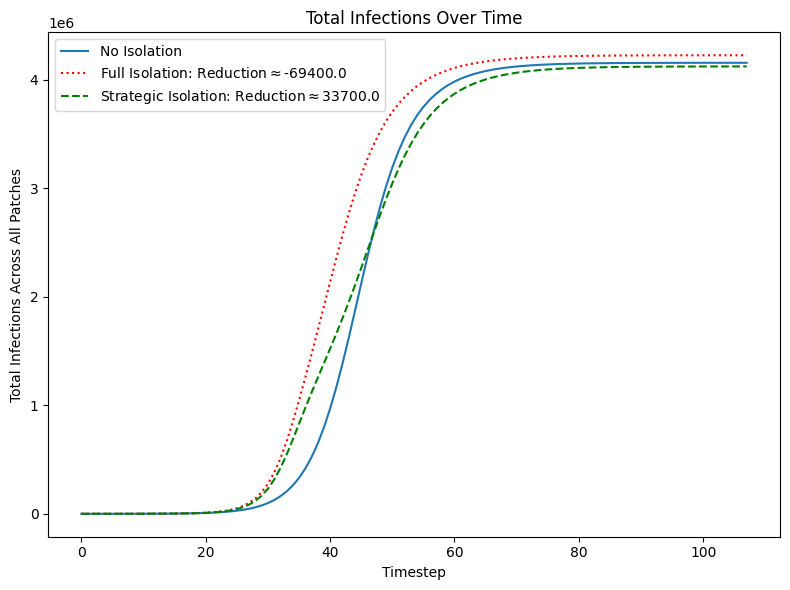

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y1_sum = solution[2][home_patches].sum(axis=0)  # shape (16,)
y2_sum = solution_best_iso[2][home_patches].sum(axis=0)  # shape (16,)
y3_sum = solution_full_iso[2][home_patches].sum(axis=0)
timesteps = np.arange(solution.shape[2])

plt.figure(figsize=(8,6))
plt.plot(timesteps, y1_sum, label='No Isolation')
plt.plot(timesteps, y3_sum, label=f'Full Isolation: Reduction$\\approx${np.round(y1_sum[-1]-y3_sum[-1],-2)}', linestyle=':', color='red')
plt.plot(timesteps, y2_sum, label=f'Strategic Isolation: Reduction$\\approx${np.round(y1_sum[-1]-y2_sum[-1],-2)}', linestyle='--', color='green')
plt.xlabel('Timestep')
plt.ylabel('Total Infections Across All Patches')
plt.title('Total Infections Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y1_sum-y2_sum

array([      0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,     -61.50432226,
          -198.62818252,    -467.3860745 ,    -957.58160748,
         -1810.95116927,   -3248.05344693,   -5607.33944601,
         -9400.29690634,  -15385.80147008,  -24662.76075974,
        -38768.69467656,  -59746.18671516,  -90091.39586091,
       -132431.59131086, -188736.69363828, -258986.55755094,
       -339676.80383144, -423246.76801143, -499565.78651847,
       -559089.29997963, -595503.46094751, -606240.65730567,
       -591445.25180977, -552859.03098672, -493359.50452495,
       -416995.49189782, -329042.71167596, -235735.96779118,
       -143616.49964852,  -58660.12649625,   14542.07190372,
         73298.0720545 ,

In [ ]:
with open("Longer 60 Day Take 2 16 Day Patch Isolation Benefits Progress.pkl", "rb") as f:
    patch_isolation_benefits = pickle.load(f)

In [ ]:
with open("Longer 60 Day take 2 total_infections_prevented_progress.pkl", "rb") as f:
    total_infections_prevented = pickle.load(f)


In [ ]:
np.max(total_infections_prevented)

np.float64(33734.91622685641)

In [ ]:
total_infections_prevented.index(33734.91622685641)

51

In [ ]:
patch_isolation_effects = np.array(patch_isolation_benefits)

top_n_indices = np.argsort(-patch_isolation_effects)[:51]

In [ ]:
top_n_indices.shape

(52,)

In [ ]:
with open("Longer 60 Day Take 2 16 Day Patch Isolation Benefits Progress.pkl", "rb") as f:
    patch_isolation_benefits = pickle.load(f)

with open("Longer 60 Day take 2 total_infections_prevented_progress.pkl", "rb") as f:
    total_infections_prevented = pickle.load(f)

def get_patch_station_names(patch_indices, station_list):
    return [station_list[idx] for idx in patch_indices]

patch_isolation_effects = np.array(patch_isolation_benefits)

top_n_indices = np.argsort(-patch_isolation_effects)[:52]
patch_station_names = get_patch_station_names(top_n_indices, station_list)

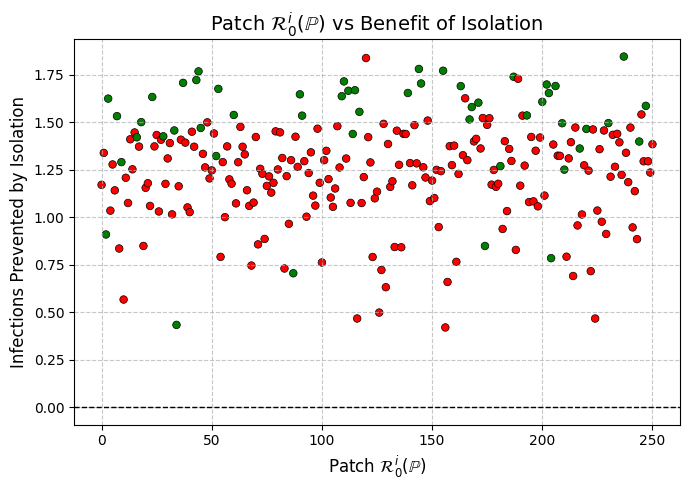

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(patch_R0s), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(range(251), patch_R0s, c=colors, s=30, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # <-- added dashed line at y=0
plt.xlabel(r'Patch $\mathcal{R}_0^i(\mathbb{P})$', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title(r'Patch $\mathcal{R}_0^i(\mathbb{P})$ vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


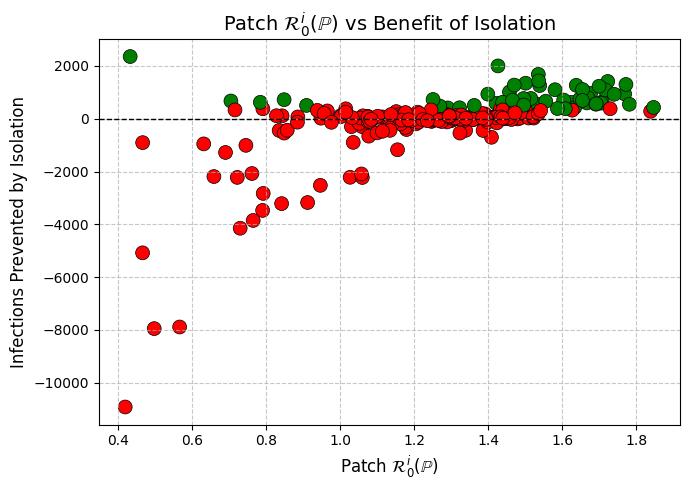

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(patch_R0s), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(patch_R0s, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # <-- added dashed line at y=0
plt.xlabel(r'Patch $\mathcal{R}_0^i(\mathbb{P})$', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title(r'Patch $\mathcal{R}_0^i(\mathbb{P})$ vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


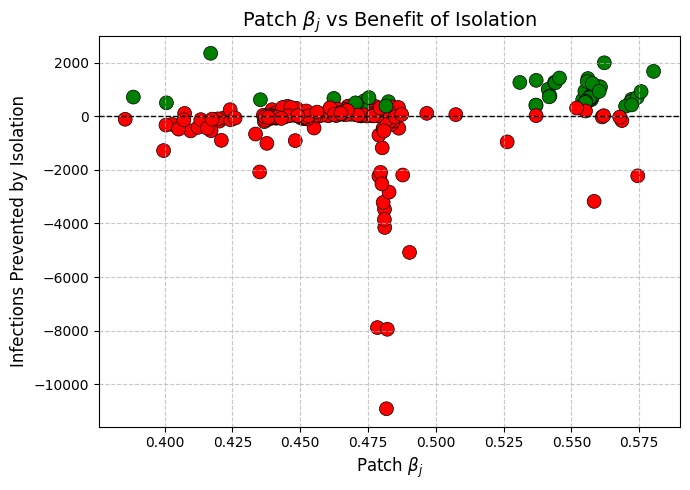

In [ ]:
plt.figure(figsize=(7,5))
colors = np.full(len(home_betas), 'red', dtype=object)
colors[top_n_indices] = 'green'

plt.scatter(home_betas, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # <-- added dashed line at y=0
plt.xlabel(r'Patch $\beta_j$', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title(r'Patch $\beta_j$ vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


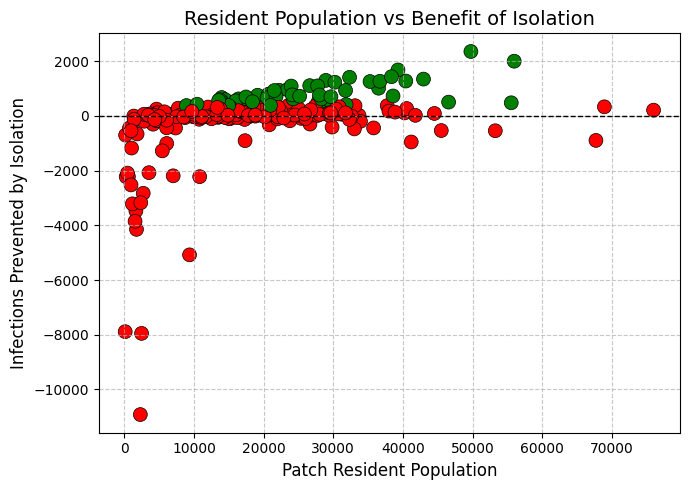

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(short_pop_vector), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(short_pop_vector, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # dashed line at y=0
plt.xlabel('Patch Resident Population', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title('Resident Population vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


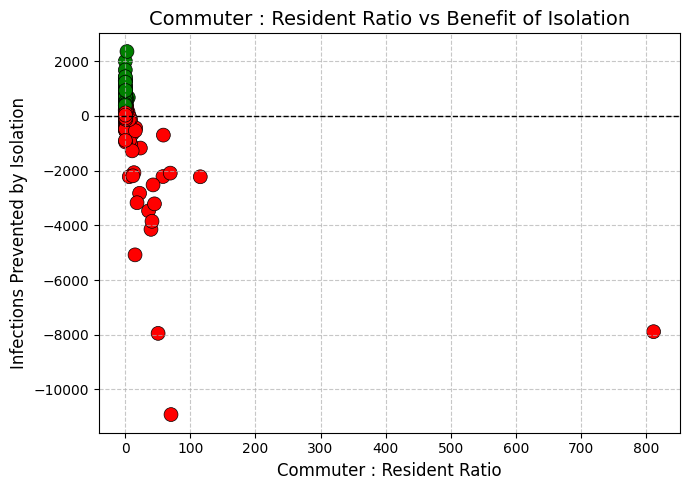

In [ ]:
with open("London P Populations.pkl", "rb") as file:
    p_populations = pickle.load(file)


commuters_vs_residents = []
for i in range(251):
    residents = np.sum(p_populations[i])
    col_sum = np.sum(p_populations.T[i])
    commuters = col_sum - p_populations[i][i]
    commuters_vs_residents.append(commuters/residents)
commuters_vs_residents = np.array(commuters_vs_residents)
commuters_vs_residents

import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(commuters_vs_residents), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(commuters_vs_residents, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # dashed line at y=0
plt.xlabel('Commuter : Resident Ratio', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title('Commuter : Resident Ratio vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


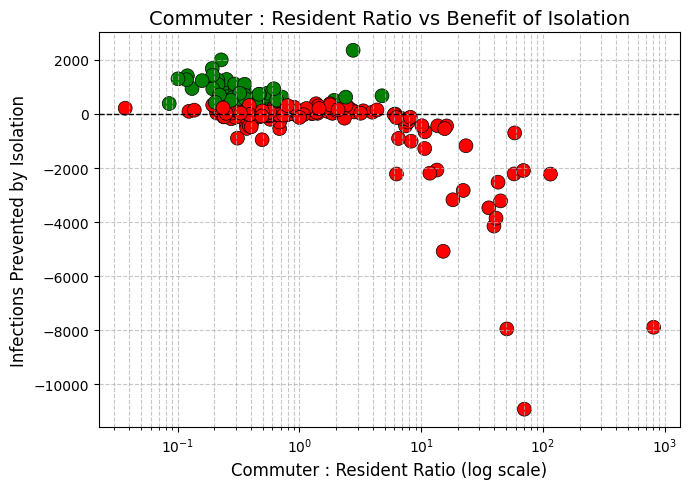

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load populations
with open("London P Populations.pkl", "rb") as file:
    p_populations = pickle.load(file)

# Compute commuter : resident ratios
commuters_vs_residents = []
for i in range(251):
    residents = np.sum(p_populations[i])
    col_sum = np.sum(p_populations.T[i])
    commuters = col_sum - p_populations[i][i]
    commuters_vs_residents.append(commuters / residents)
commuters_vs_residents = np.array(commuters_vs_residents)

# Initialize all red
colors = np.full(len(commuters_vs_residents), 'red', dtype=object)
colors[top_n_indices] = 'green'  # Assuming top_n_indices already defined

# Plot
plt.figure(figsize=(7,5))
plt.scatter(commuters_vs_residents, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.xscale('log')  # <-- Log base 10 scaling on x-axis
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Commuter : Resident Ratio (log scale)', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title('Commuter : Resident Ratio vs Benefit of Isolation', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
best_iso_patch_improvement

array([  425.62513783,    82.63113341,  1678.70710173,  -763.82475712,
        1060.83367158,   774.27405911,   442.86255074, -1953.97972292,
         533.37786879,  -719.28076699,    12.08549747,   411.98435529,
         571.95678929,    21.82502869,   503.5868103 ,   270.06205787,
       -2135.52449096,   521.58569693, -2139.85894302,  1173.11538424,
          90.48646082,   324.05880536,   302.52663127,  -736.84665287,
         188.63094618,   429.84648143,   622.87231404,   298.12927685,
       -2437.42482843,   345.04049474,   457.80702218,   481.82070746,
         744.68159284, -1623.81704312,  9933.71154335,   183.27584174,
          16.93127118,  -715.5625235 ,   428.44357196,   331.00463208,
          53.88703144,     5.42192728,   195.96921256, -1628.98388872,
       -1107.8461704 , -1852.01806177,   201.40814251,   569.49087508,
         110.15569021,   208.7294024 ,   180.01397434,    11.40179977,
       -2005.44487056, -1124.86460221,   919.37917414,   227.98761526,
      

In [ ]:
max_index = np.argmax(best_iso_patch_improvement)
max_index
station_list[34]

'Canary Wharf'

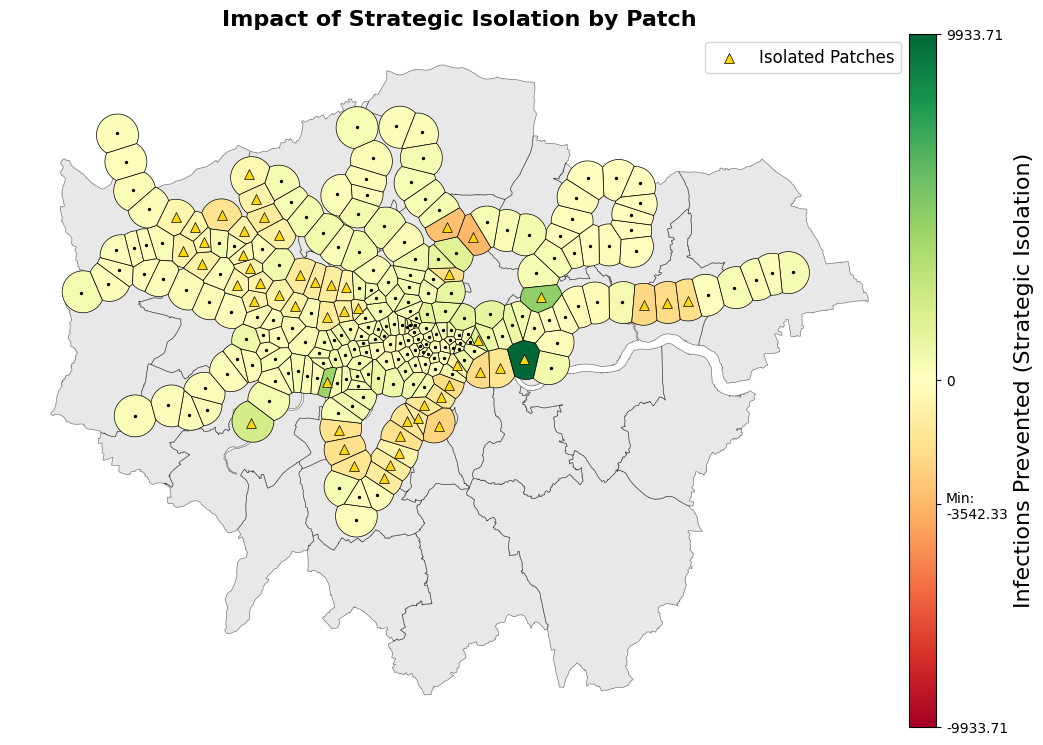

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

# Assume 'solution', 'solution_best_iso', 'solution_full_iso', 'home_patches', and 'top_n_indices' are already loaded

original_ending = solution[2][home_patches].T[-1]  # shape (16,)
best_iso_ending = solution_best_iso[2][home_patches].T[-1]  # shape (16,)
full_iso_ending = solution_full_iso[2][home_patches].T[-1]

best_iso_patch_improvement = original_ending - best_iso_ending

# Load shapefiles
voronoi_gdf = gpd.read_file("London_Voronoi_File_1_5km.shp")
london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")
boroughs_gdf = london_gdf[london_gdf["type"] == "borough"]

voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)



voronoi_gdf["effects"] = best_iso_patch_improvement


# Plot
fig, ax = plt.subplots(figsize=(12, 9))
boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0)

vmin_raw = voronoi_gdf.loc[voronoi_gdf["effects"] != 0, "effects"].min()
vmax_raw = voronoi_gdf.loc[voronoi_gdf["effects"] != 0, "effects"].max()
abs_max = max(abs(vmin_raw), abs(vmax_raw))
vmin, vmax = -abs_max, abs_max

norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# Nonzero patches
nonzero = voronoi_gdf["effects"] != 0
voronoi_gdf[nonzero].plot(
    ax=ax,
    column="effects",
    cmap="RdYlGn",
    norm=norm,
    edgecolor="black",
    linewidth=0.5,
    alpha=1,
)

# Zero patches
if (~nonzero).any():
    voronoi_gdf[~nonzero].plot(
        ax=ax,
        color="gray",
        edgecolor="black",
        linewidth=0.5,
        alpha=1,
    )

# Colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Infections Prevented (Strategic Isolation)", fontsize=16)

ticks = [vmin, 0, vmax]
tick_labels = [f"{vmin:.2f}", "0", f"{vmax:.2f}"]

# Add raw vmin if it differs significantly
if np.abs(vmin_raw - vmin) > 1e-5:
    ticks.insert(0, vmin_raw)
    tick_labels.insert(0, f"Min:\n{vmin_raw:.2f}")

# Add raw vmax if it differs significantly
if np.abs(vmax_raw - vmax) > 1e-5:
    ticks.append(vmax_raw)
    tick_labels.append(f"Max:\n{vmax_raw:.2f}")

cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(tick_labels)
# Centroids
voronoi_centroids = voronoi_gdf.centroid
voronoi_centroids = gpd.GeoSeries(voronoi_centroids, crs="EPSG:3857")

# Split top_n_indices vs others
top_n_centroids = voronoi_centroids.iloc[top_n_indices]
other_centroids = voronoi_centroids.drop(index=top_n_indices)

# Plot other centroids (black dots)
other_centroids.plot(ax=ax, color="black", markersize=2)

# Plot top_n centroids (gold triangles)
ax.scatter(
    top_n_centroids.x, top_n_centroids.y,
    color="gold", marker="^", s=50, edgecolor="black", linewidth=0.5
)

# Add legend for isolated patches
ax.scatter([], [], color="gold", marker="^", s=50, edgecolor="black", linewidth=0.5, label="Isolated Patches")
ax.legend(loc="upper right", fontsize=12, frameon=True)


ax.set_title("Impact of Strategic Isolation by Patch", fontweight='bold', fontsize=16)
ax.axis("off")
plt.show()

In [ ]:
best_iso_ending.shape

(251,)

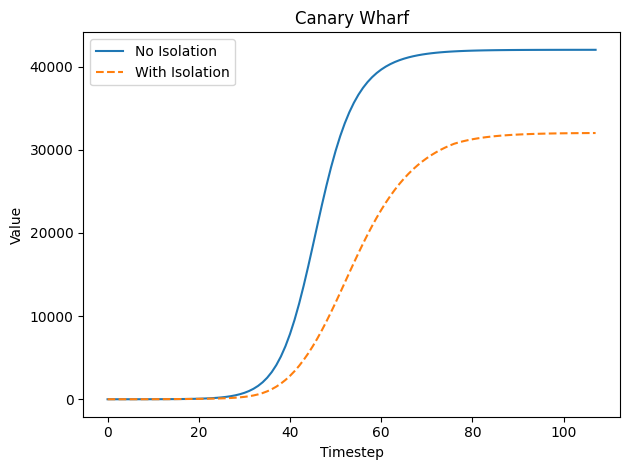

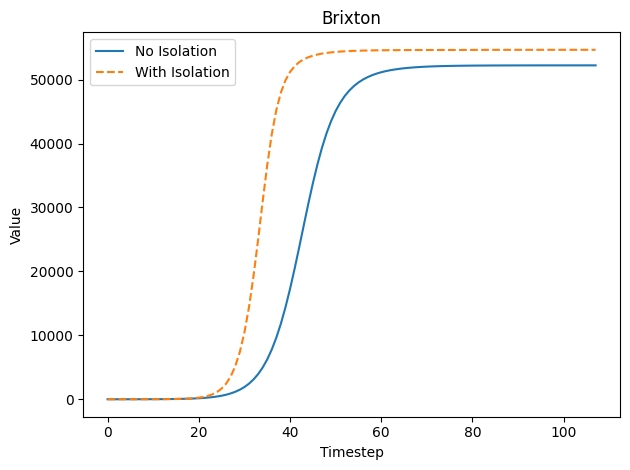

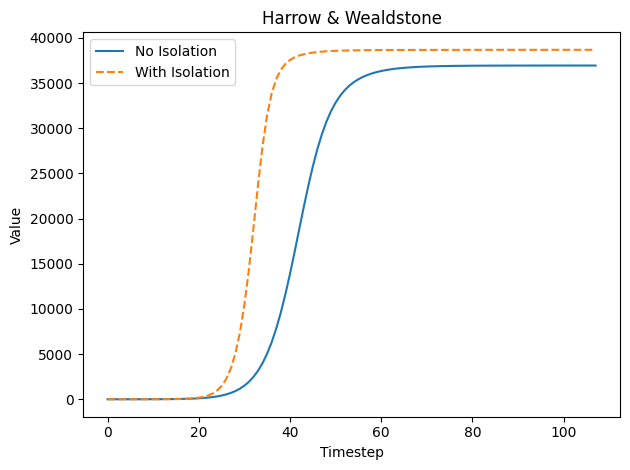

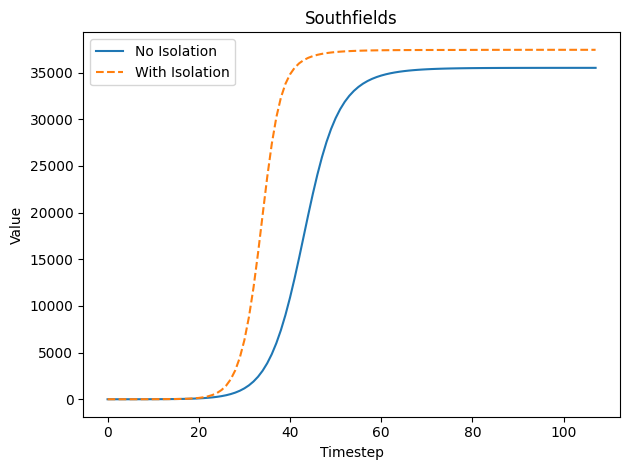

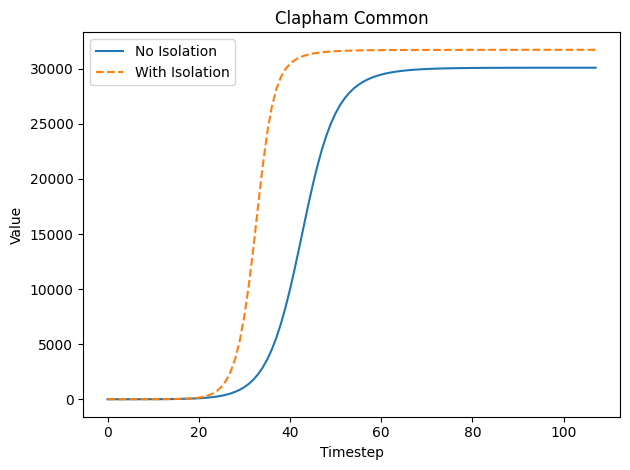

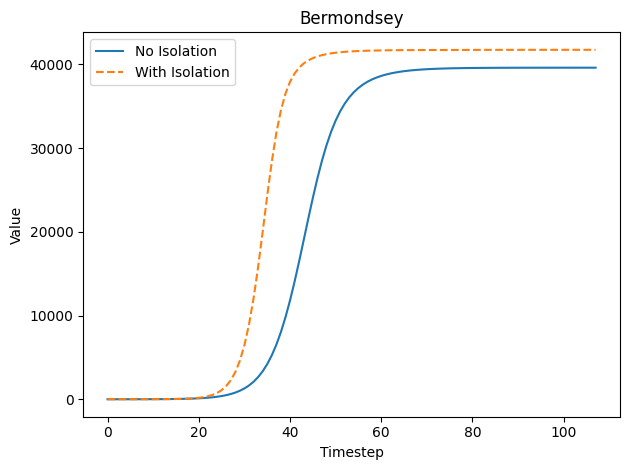

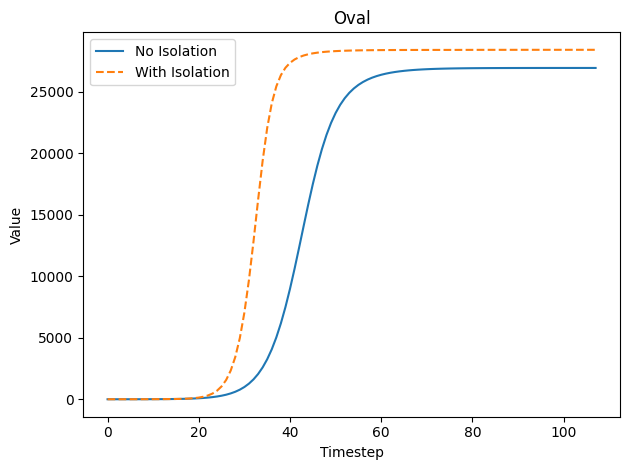

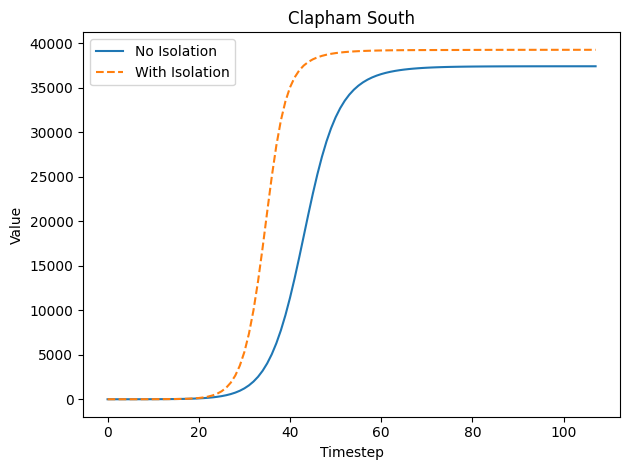

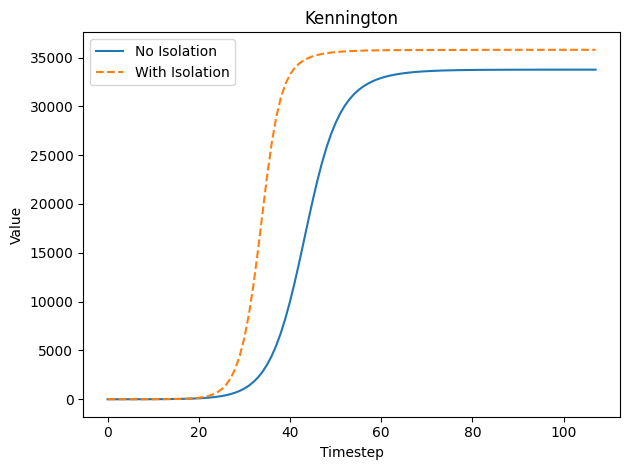

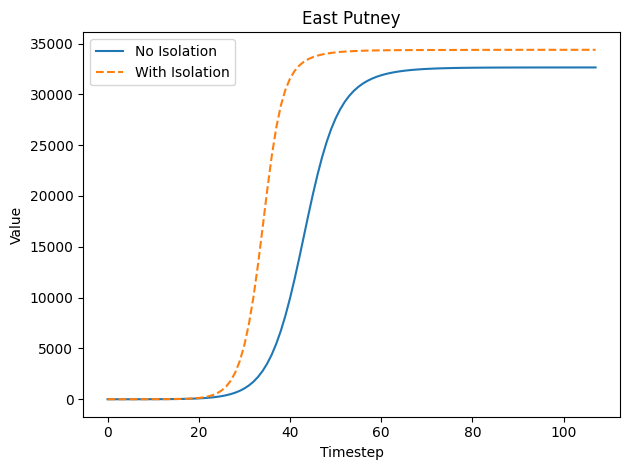

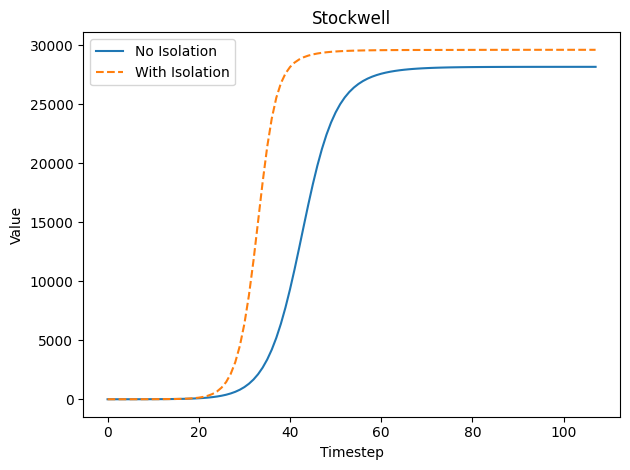

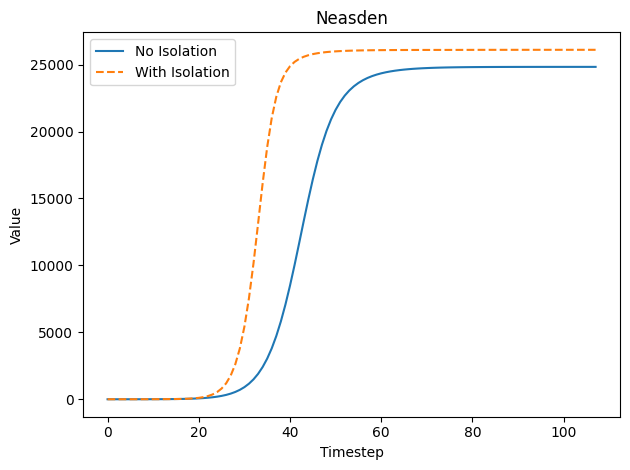

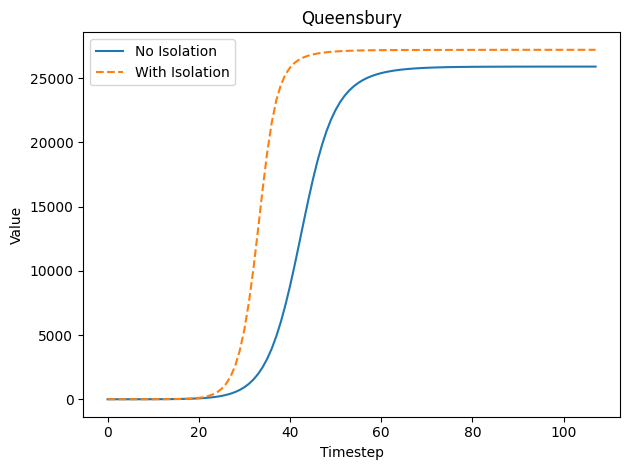

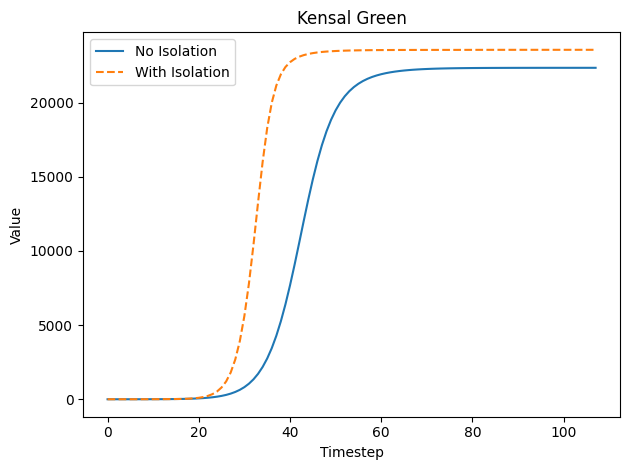

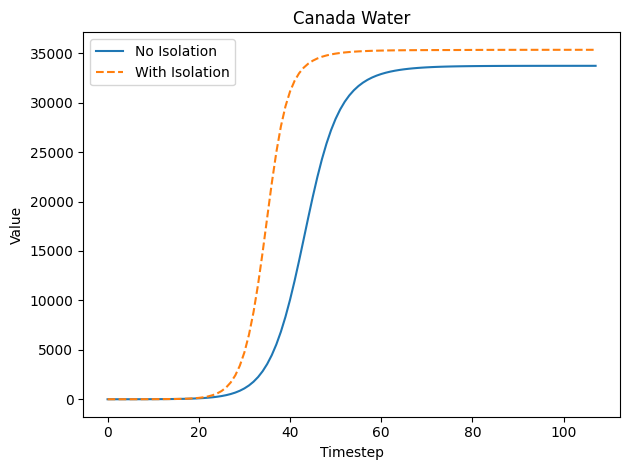

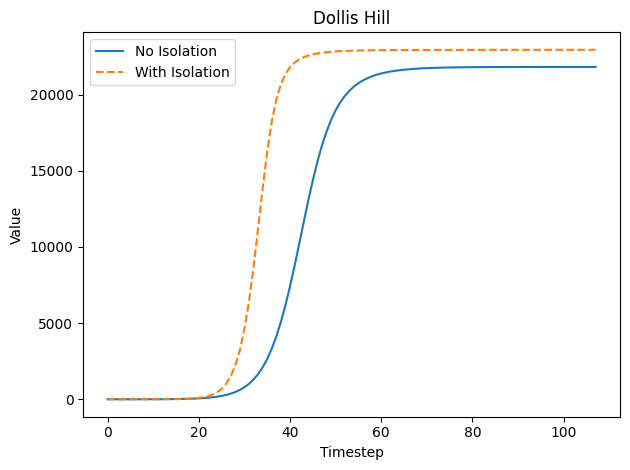

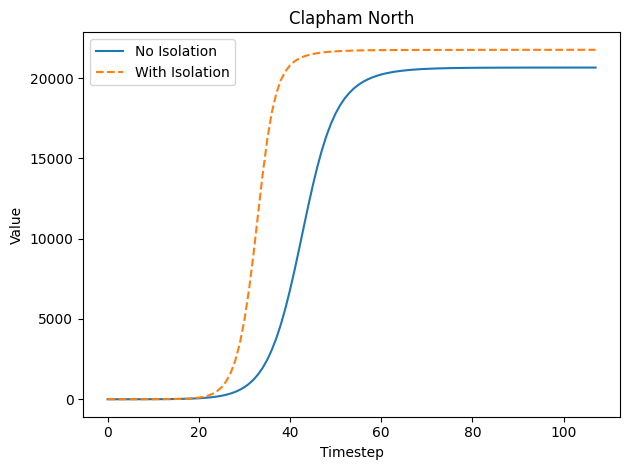

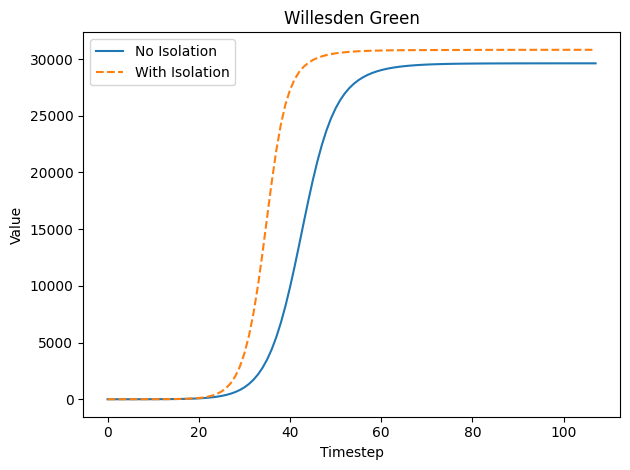

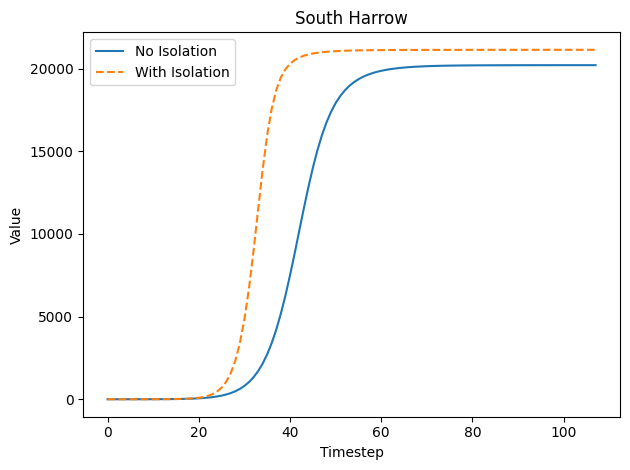

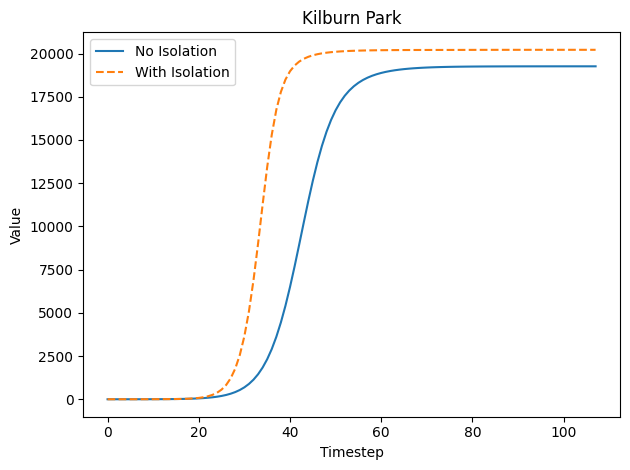

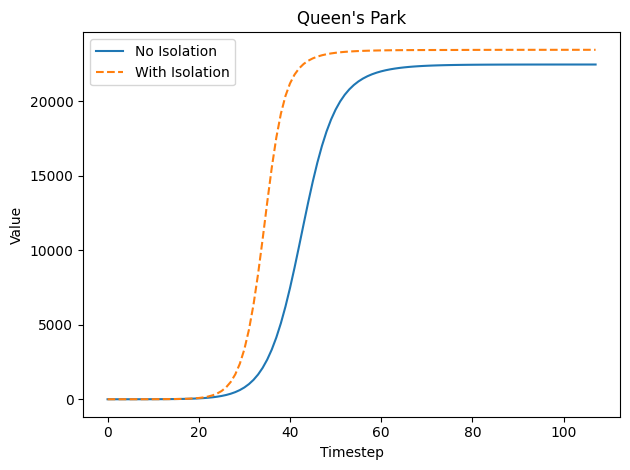

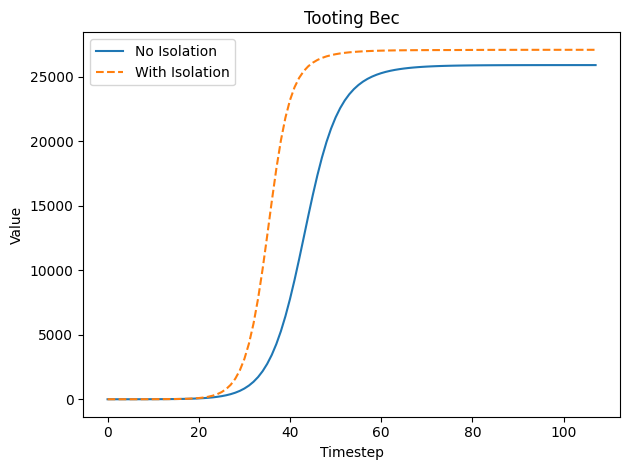

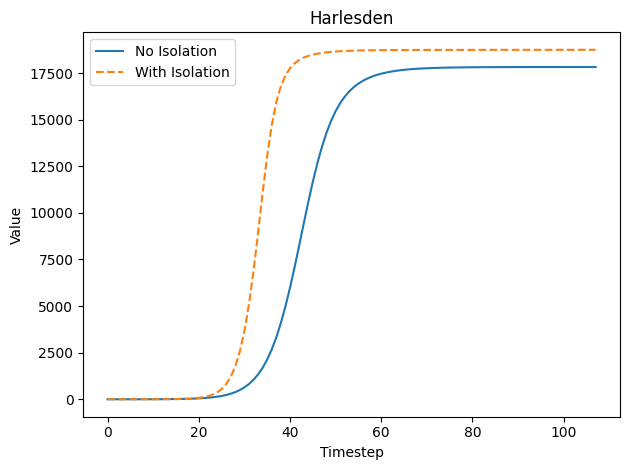

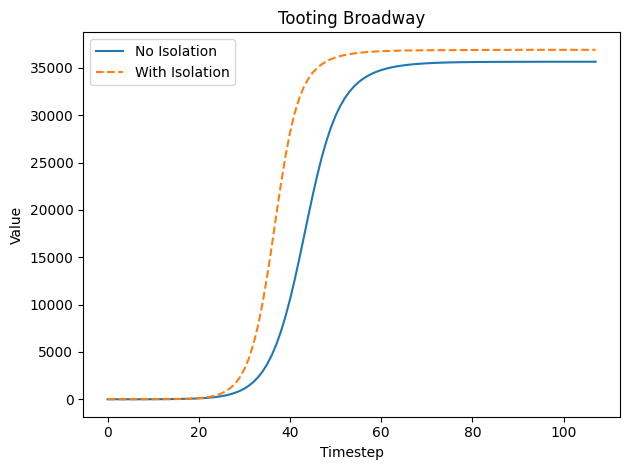

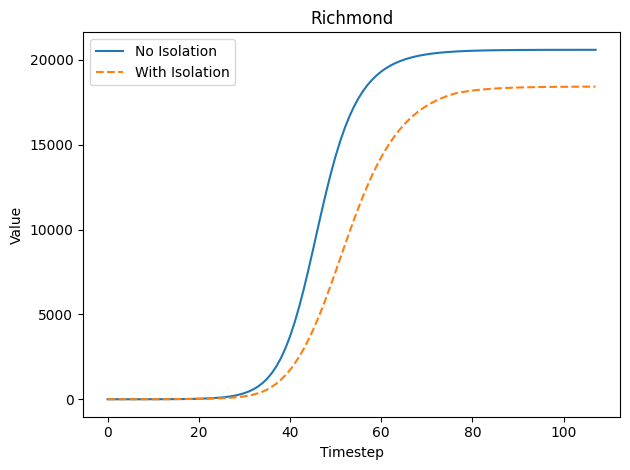

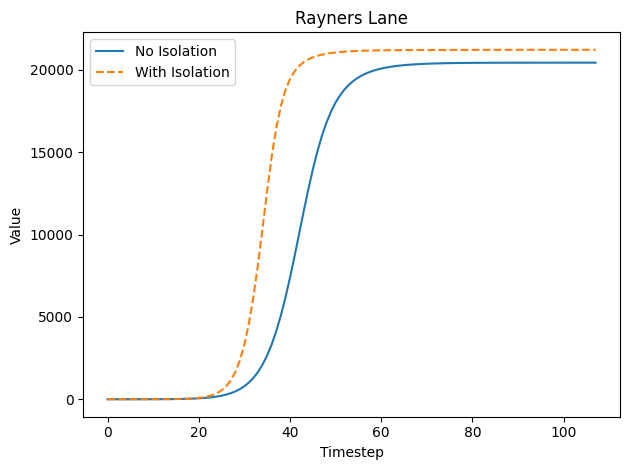

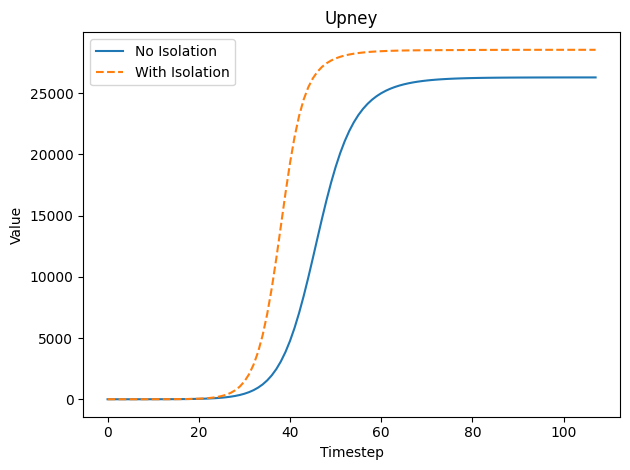

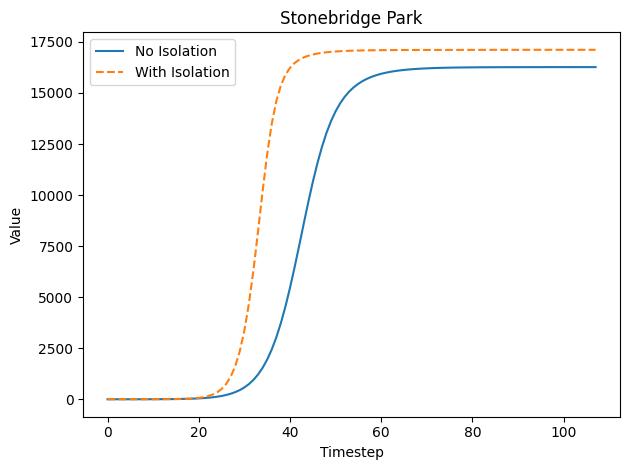

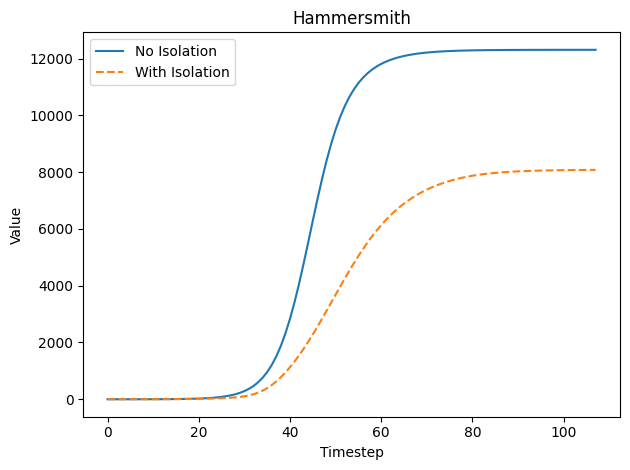

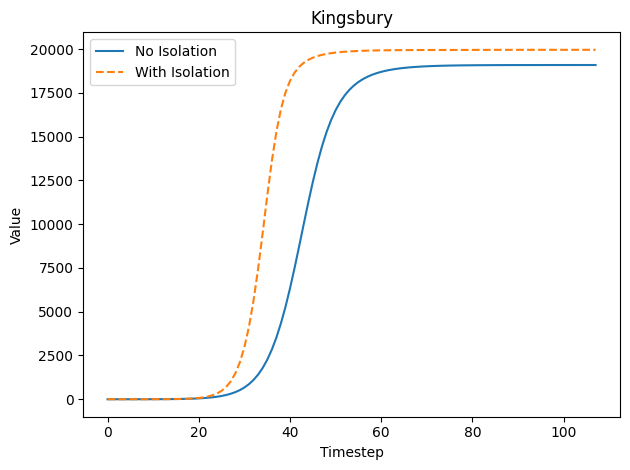

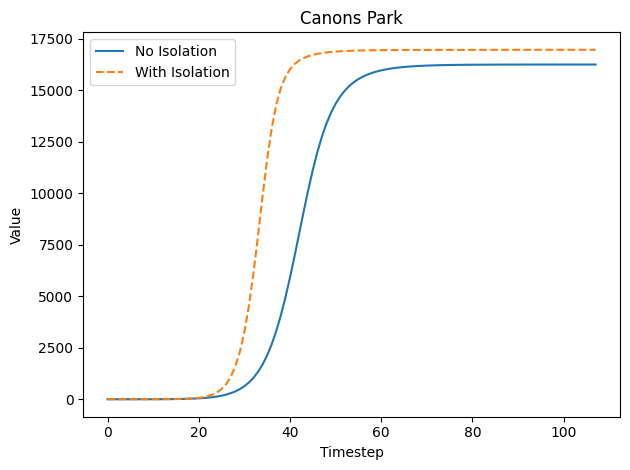

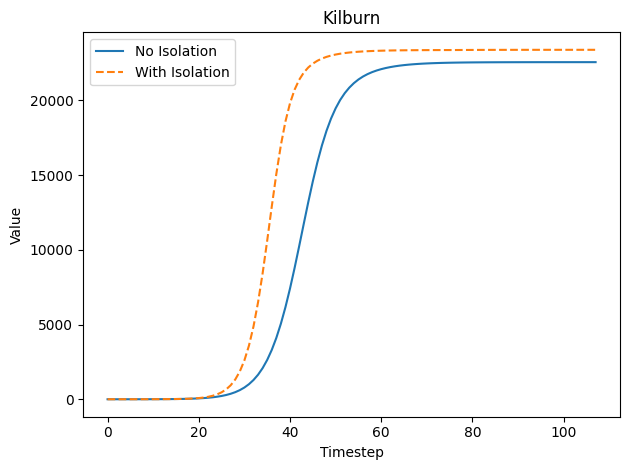

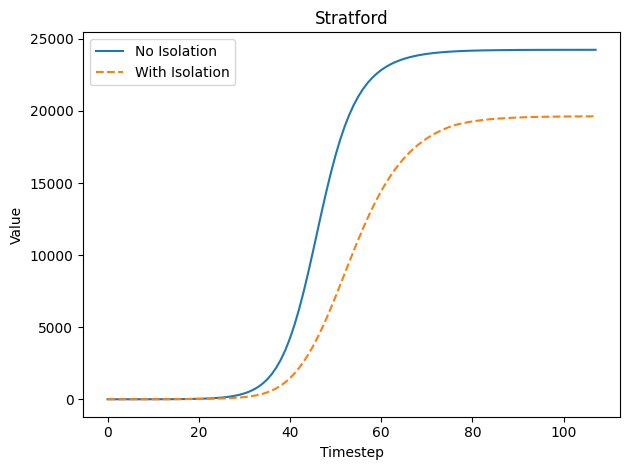

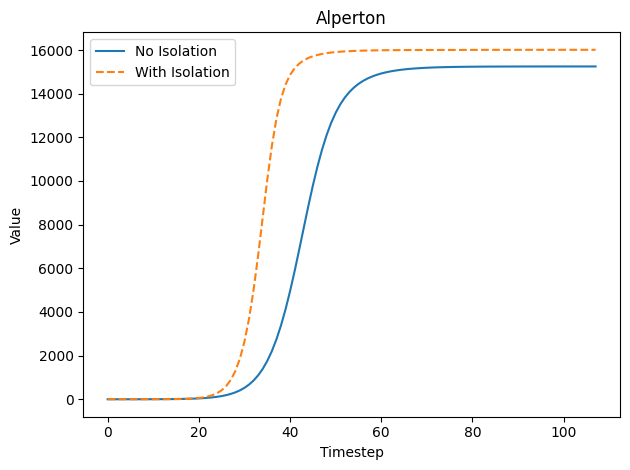

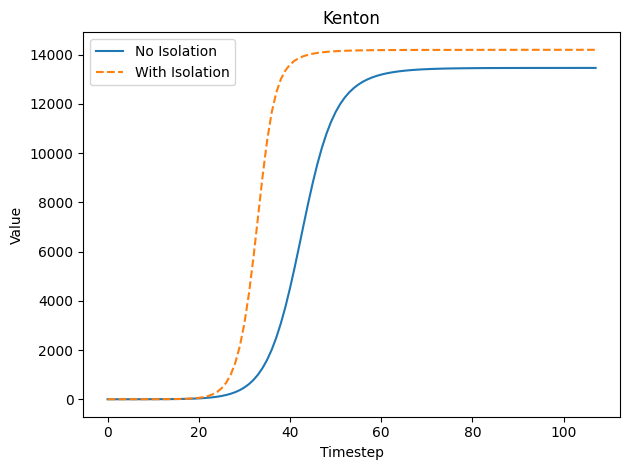

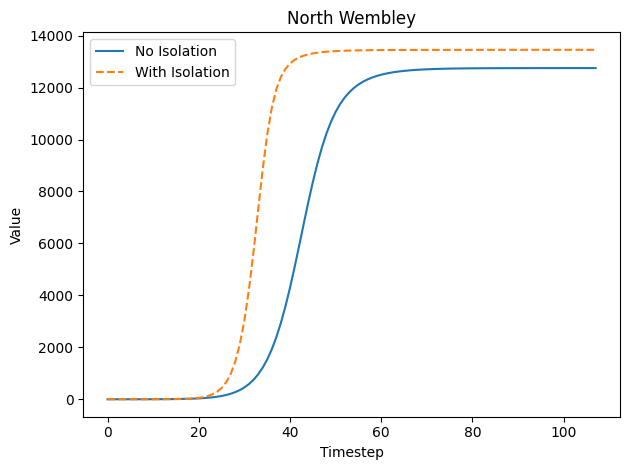

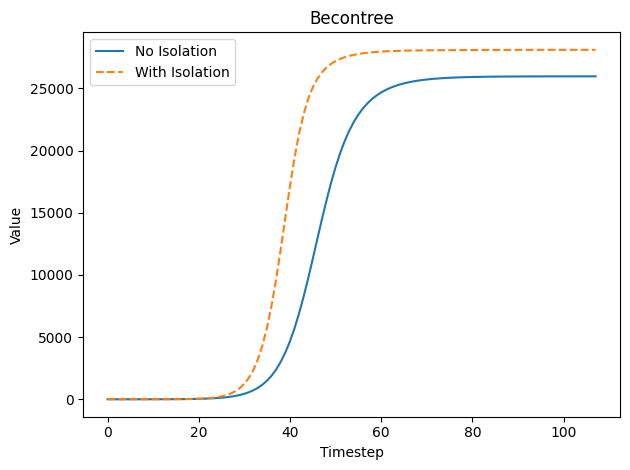

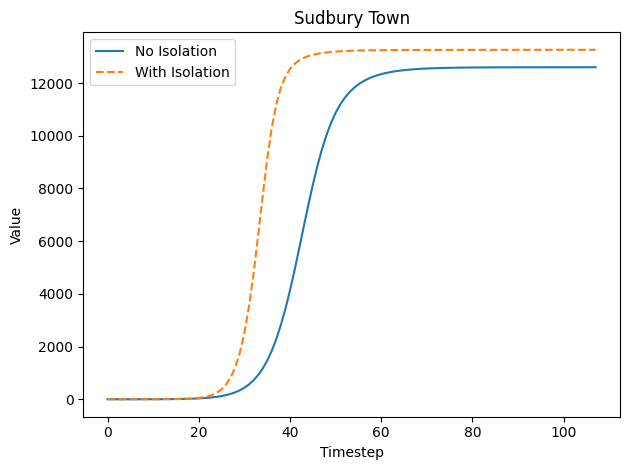

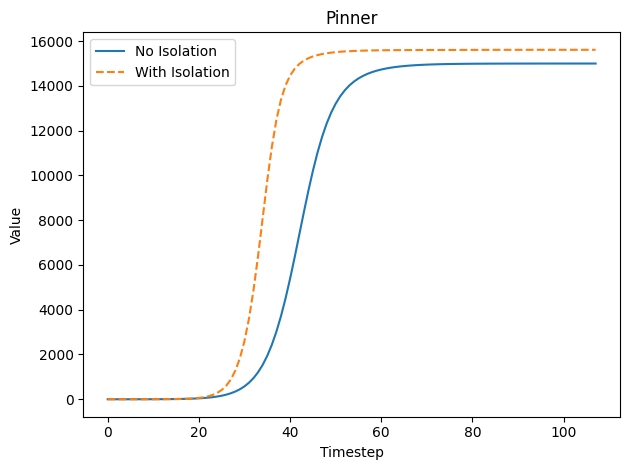

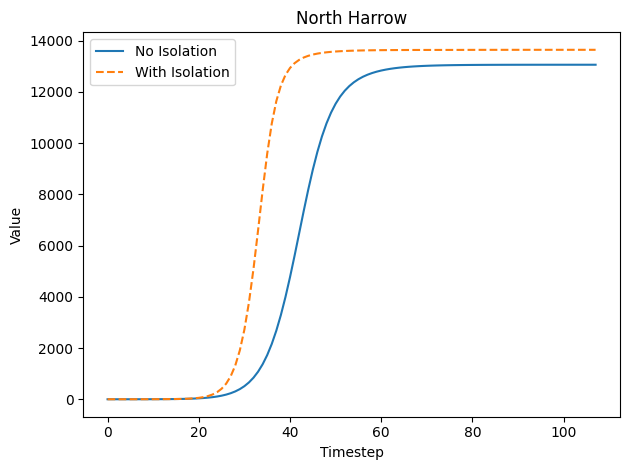

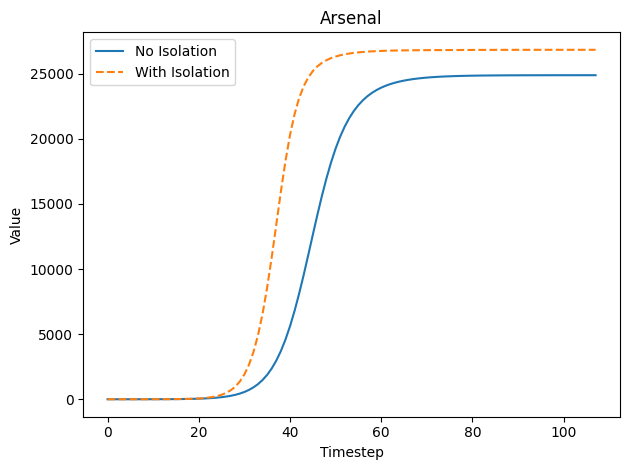

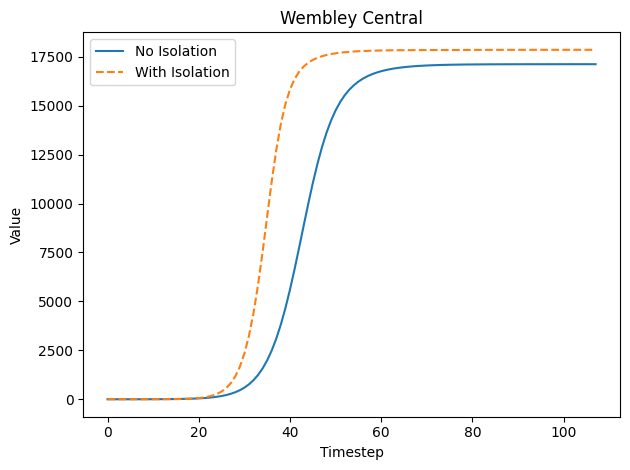

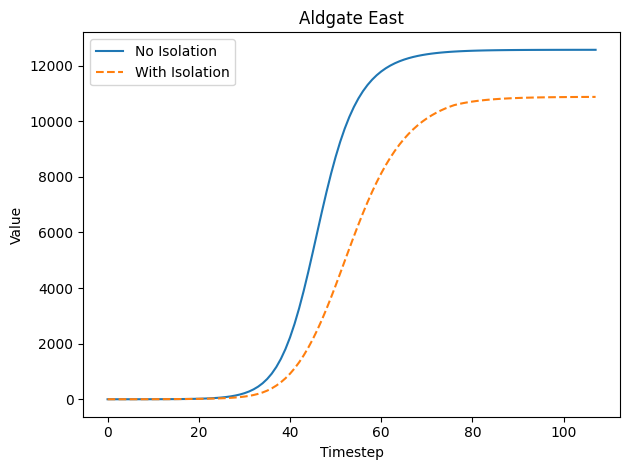

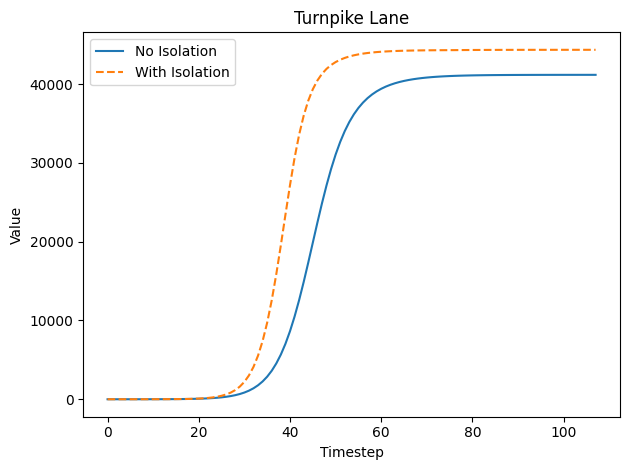

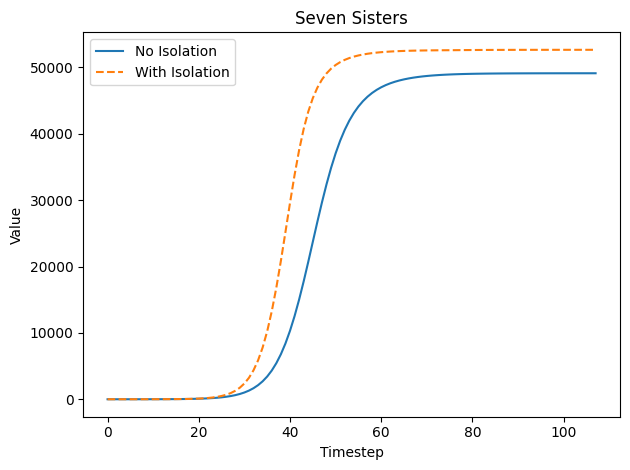

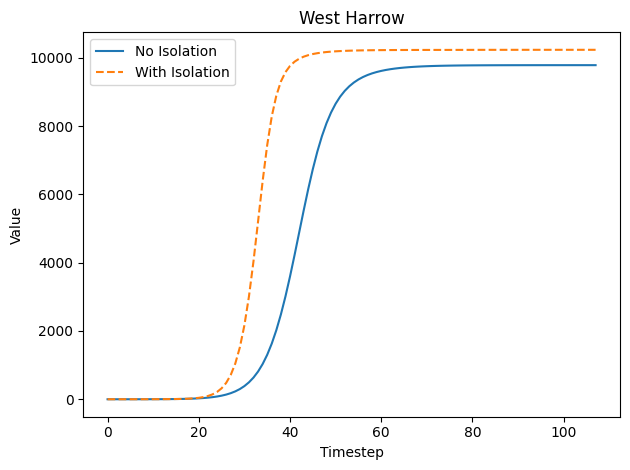

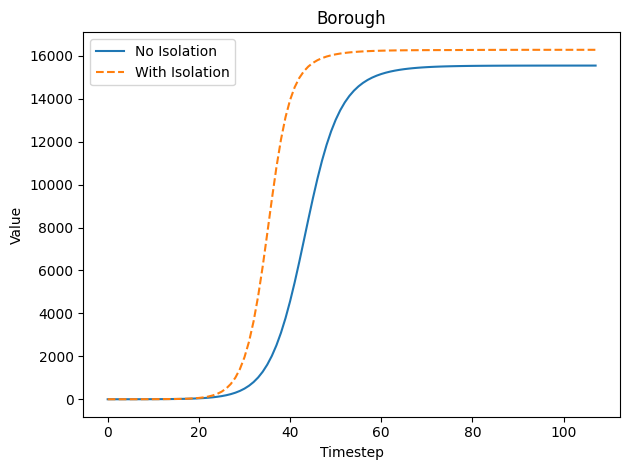

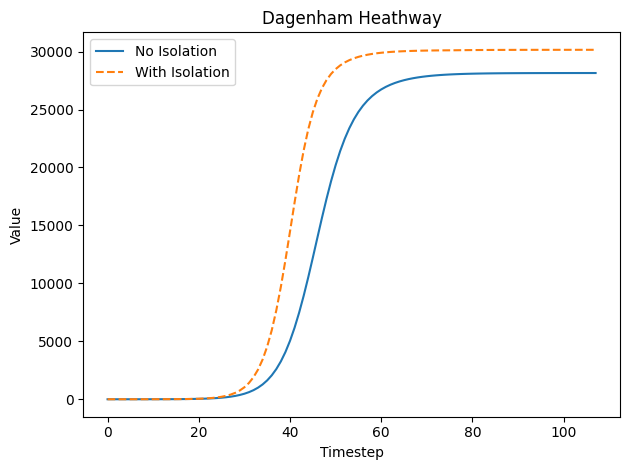

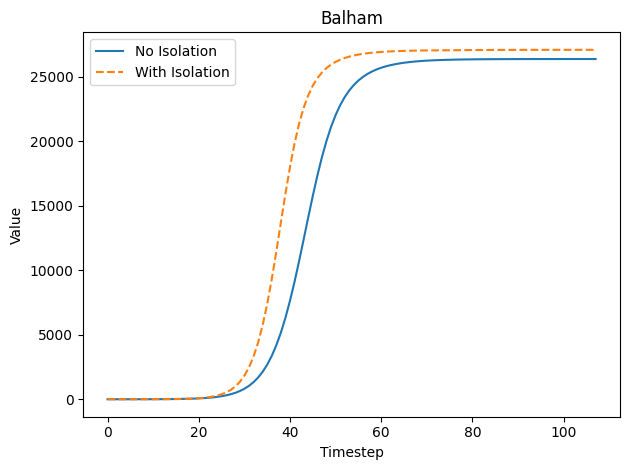

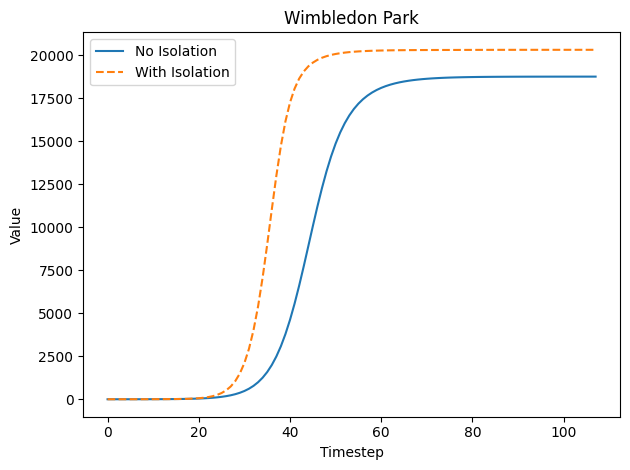

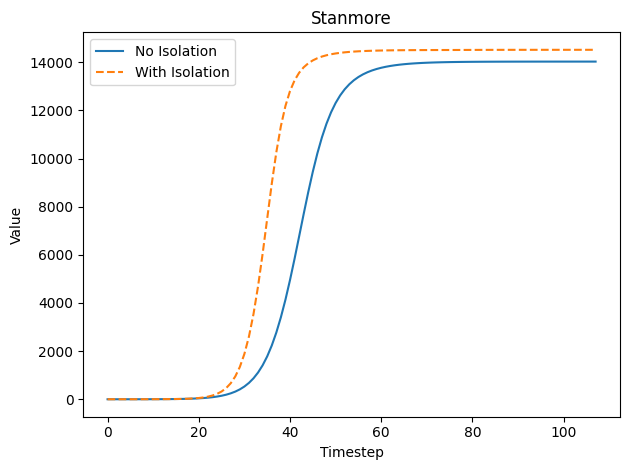

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume: both arrays are shaped (251, 16)
y1 = solution[2][home_patches]  # shape (251, 16)
y2 = solution_with_iso[2][home_patches]  # shape (251, 16)
timesteps = np.arange(solution.shape[2])

for i in top_n_indices:
    plt.figure()
    plt.plot(timesteps, y1[i], label='No Isolation')
    plt.plot(timesteps, y2[i], label='With Isolation', linestyle='--')
    plt.title(f'{station_list[i]}')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
np.sum(np.array([[1,2,3],[1,2,3]]),axis=0)

array([2, 4, 6])

In [ ]:
second_p_matrix.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
# Get populations at the given indices
selected_pops = short_pop_vector[indices]

# Get populations not at the given indices
all_indices = np.arange(len(short_pop_vector))
complement_indices = np.setdiff1d(all_indices, indices)
complement_pops = short_pop_vector[complement_indices]

# Calculate averages
mean_selected = np.mean(selected_pops)
mean_complement = np.mean(complement_pops)

print("Mean at selected indices:", mean_selected)
print("Mean at non-selected indices:", mean_complement)

Mean at selected indices: 16208.305718928352
Mean at non-selected indices: 20400.933402814087


In [ ]:
y1_sum-y2_sum

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.02773751,   0.07580066,   0.15322268,
         0.27248187,   0.45069306,   0.71116677,   1.08542525,
         1.61576951,   2.35848023,   3.38769227,   4.79987809,
         6.71866206,   9.29929012,  12.73138897,  17.2375316 ,
        23.06347706,  30.45385792,  39.60523197,  50.58885364,
        63.24283749,  77.05521138,  91.10274981, 104.16656436,
       115.15697946, 123.82055355, 131.27869092, 139.54450605,
       149.64344219, 159.69503767, 165.34101968, 162.74079877,
       151.21268377, 133.16885492, 112.18683768,  91.28416626,
        72.2774233 ,  55.92193746,  42.2993691 ,  31.15697322,
        22.12316684,  14.81991688,   8.91083251,   4.11528387,
         0.20693236,  -2.99361447,  -5.62741755,  -7.80516812,
        -9.61386879, -11.12217577, -12.38456155, -13.44451479,
       -14.33698433, -15.09024286, -15.72731021, -16.26

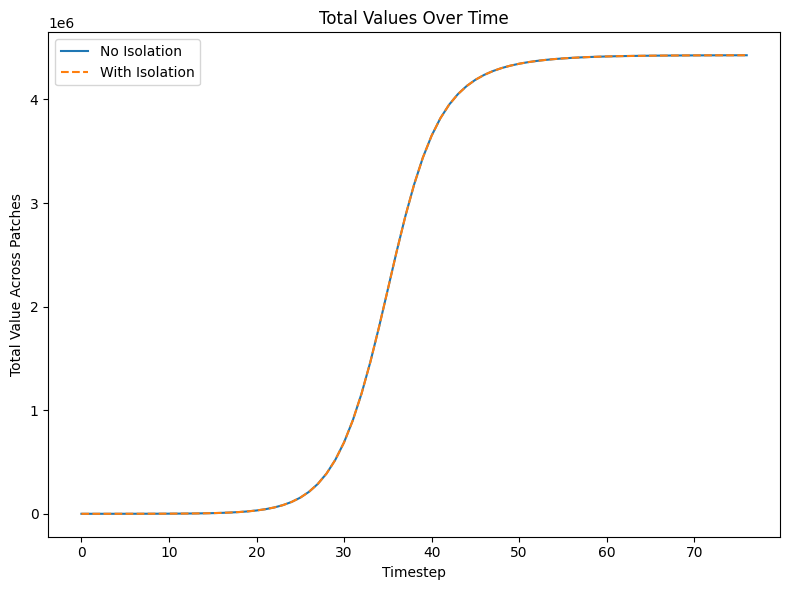

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y1_sum = solution[2][home_patches].sum(axis=0)  # shape (16,)
y2_sum = solution_with_iso[2][home_patches].sum(axis=0)  # shape (16,)
timesteps = np.arange(solution.shape[2])

plt.figure(figsize=(8,6))
plt.plot(timesteps, y1_sum, label='No Isolation')
plt.plot(timesteps, y2_sum, label='With Isolation', linestyle='--')
plt.xlabel('Timestep')
plt.ylabel('Total Value Across Patches')
plt.title('Total Values Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import numpy as np
import os
import tempfile
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import timedelta, datetime
from tqdm import tqdm  # Progress bar
import IPython


pop_array = np.array(list(pop_dict.values()))

def create_voronoi_gif(solution, params, label_mode="number"):
    output_filename = "testing_quarantine_london.gif"
    voronoi_gdf = gpd.read_file("London_Voronoi_File_1_5km.shp")
    london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")
    map_data = solution
    station_data = map_data[1][home_patches]

    num_timesteps = station_data.shape[1]
    for i in range(251):
        station_data[i] = station_data[i] / pop_array[i]

    voronoi_gdf = voronoi_gdf.to_crs(london_gdf.crs)
    boroughs_gdf = london_gdf[london_gdf['type'] == 'borough']
    stations_gdf = london_gdf[london_gdf['type'] == 'station']
    start_date = datetime(2020, 3, 7)

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            color_values = station_data[:, t]
            color_min, color_max = np.nanmin(color_values), np.nanmax(color_values)
            if color_max > color_min:
                voronoi_gdf["color"] = (color_values - color_min) / (color_max - color_min)
            else:
                voronoi_gdf["color"] = 0.5

            fig, ax = plt.subplots(figsize=(6, 6))
            boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)
            voronoi_gdf.plot(ax=ax, column="color", cmap="plasma", edgecolor="black", linewidth=0.5, alpha=1)
            stations_gdf.plot(ax=ax, color="black", markersize=1)

            label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y") if label_mode == "date" else f"t = {t}"
            ax.text(0.5, 1.01, label_text, transform=ax.transAxes, fontsize=12, ha="center", va="bottom", fontweight="bold")
            ax.set_axis_off()
            plt.tight_layout(pad=0)

            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            frames.append(imageio.imread(temp_filepath))

        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')

# Example usage:
create_voronoi_gif(solution, params, label_mode="date")


Generating Frames: 100%|██████████| 77/77 [00:22<00:00,  3.36frame/s]


Creating GIF...


In [ ]:
import geopandas as gpd
import numpy as np
import os
import tempfile
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import timedelta, datetime
from tqdm import tqdm  # Progress bar
import IPython


pop_array = np.array(list(pop_dict.values()))

def create_voronoi_gif(solution, params, label_mode="number"):
    output_filename = "testing_quarantine_london_iso.gif"
    voronoi_gdf = gpd.read_file("London_Voronoi_File_1_5km.shp")
    london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")
    map_data = solution
    station_data = map_data[1][home_patches]

    num_timesteps = station_data.shape[1]
    for i in range(251):
        station_data[i] = station_data[i] / pop_array[i]

    voronoi_gdf = voronoi_gdf.to_crs(london_gdf.crs)
    boroughs_gdf = london_gdf[london_gdf['type'] == 'borough']
    stations_gdf = london_gdf[london_gdf['type'] == 'station']
    start_date = datetime(2020, 3, 7)

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            color_values = station_data[:, t]
            color_min, color_max = np.nanmin(color_values), np.nanmax(color_values)
            if color_max > color_min:
                voronoi_gdf["color"] = (color_values - color_min) / (color_max - color_min)
            else:
                voronoi_gdf["color"] = 0.5

            fig, ax = plt.subplots(figsize=(6, 6))
            boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)
            voronoi_gdf.plot(ax=ax, column="color", cmap="plasma", edgecolor="black", linewidth=0.5, alpha=1)
            stations_gdf.plot(ax=ax, color="black", markersize=1)

            label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y") if label_mode == "date" else f"t = {t}"
            ax.text(0.5, 1.01, label_text, transform=ax.transAxes, fontsize=12, ha="center", va="bottom", fontweight="bold")
            ax.set_axis_off()
            plt.tight_layout(pad=0)

            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            frames.append(imageio.imread(temp_filepath))

        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')

# Example usage:
create_voronoi_gif(solution_with_iso, params_with_iso, label_mode="date")


Generating Frames: 100%|██████████| 77/77 [00:22<00:00,  3.44frame/s]


Creating GIF...


In [ ]:
def sparse_get_associated_indices(station_idx):
    station_name = station_list[station_idx]
    associated_indices = []
    associated_homes = []
    for i in range(9):
        if station_name in pairs_list[i]:
            associated_indices.append(i)
            associated_homes.append(home_patches[station_list.index(pairs_list[i][0])])
    return associated_indices, associated_homes

def sparse_isolate_patch(sparse_expanded_p_matrix, patch_idx, modification):
    from scipy.sparse import lil_matrix

    new_p = sparse_expanded_p_matrix.copy().tolil()  # stay sparse throughout
    changing_rows, home_indices = get_associated_indices(patch_idx)
    print(changing_rows, home_indices)

    for idx in tqdm(range(len(changing_rows)), desc="Isolating Patch"):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        # Scale all nonzero entries
        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        # Find the sum after scaling
        row_total = sum(row_data[1])

        # Find the original total (before scaling)
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        # Correct the home index
        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            # If home wasn't in original nonzeros, add it
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()


def get_associated_indices(station_idx):
    station_name = station_list[station_idx]
    associated_indices = []
    associated_homes = []
    mode = "everyone"

    for i in range(9):
        if station_name in pairs_list[i]:
            home_idx = home_patches[station_list.index(pairs_list[i][0])]
            if mode == "workers only":
                if home_patches[station_idx] != home_idx:
                    associated_indices.append(i)
                    associated_homes.append(home_idx)
            else:
                associated_indices.append(i)
                associated_homes.append(home_idx)
    return associated_indices,associated_homes

def isolate_patch(expanded_p_matrix,patch_idx,modification):
    new_p = expanded_p_matrix.copy()
    important_indices = get_associated_indices(patch_idx)
    changing_rows = important_indices[0]
    home_indices = important_indices[1]
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_total = np.sum(new_p[row])
        new_p[row] *= 1-modification
        new_p[row][home] += row_total - np.sum(new_p[row])

    return new_p

def convert_back_to_classic_p(fourth_phase):
    fifth_phase = np.zeros((9,9))

    for i in range(9):
        connection = connections_list[i]
        home_patch = connection[0]
        home_index = connections_list.index((home_patch,home_patch))
        fifth_phase[home_index] += fourth_phase[i]

    sixth_phase = np.zeros((9,9))

    for i in range(9):
        if np.sum(fifth_phase[i]) != 0:
            sixth_phase[i] = fifth_phase[i]/np.sum(fifth_phase[i])
        else:
            sixth_phase[i][i] = 1

    return sixth_phase


In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

def full_sparse_isolate(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i in range(9):
        pair = pairs_list[i]
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = ([], [])
            station_to_indices_homes[station][0].append(i)
            station_to_indices_homes[station][1].append(home_patches[station_list.index(pair[0])])

    # Build total set of affected rows and homes
    changing_rows = []
    home_indices = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        associated = station_to_indices_homes.get(station_name, ([], []))
        changing_rows.extend(associated[0])
        home_indices.extend(associated[1])

    # Now apply all changes
    new_p = sparse_expanded_p_matrix.copy().tolil()
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        row_total = sum(row_data[1])
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=[1],
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


modified_sparse.toarray()

array([[1345.2709    ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  13.4790929 ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   8.19027465,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,   30.48144931],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    1.83627333],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1351.2195    ]])

In [ ]:
np.sum(expanded_p_matrix,axis=1)

array([300., 200., 100., 200., 300., 190., 100., 190., 300.])

In [ ]:
get_associated_indices(2)

([2, 5], [0, 4])

array([500., 300., 200.,  45., 180.,  75.,  10.,  20.,  70.])

In [ ]:
np.round((tspent.T*workpops).T,2)

array([[500.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [175.  ,  12.5 ,   0.  ,  12.5 , 100.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [ 83.33,   8.33,   0.  ,   8.33,   0.  ,  16.67,   0.  ,  16.67,
         66.67],
       [ 15.  ,   1.88,   0.  ,   1.88,  26.25,   0.  ,   0.  ,   0.  ,
          0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  , 180.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,  37.5 ,   6.25,   0.  ,   6.25,
         25.  ],
       [  3.33,   0.42,   0.  ,   0.42,   0.  ,   0.83,   0.  ,   0.83,
          4.17],
       [  0.  ,   0.  ,   0.  ,   0.  ,   6.67,   1.67,   0.  ,   1.67,
         10.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         70.  ]])

In [ ]:
def full_sparse_isolate_fast(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i, pair in enumerate(pairs_list[:9]):
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = []
            station_to_indices_homes[station].append((i, home_patches[station_list.index(pair[0])]))

    # Collect affected rows and homes
    changing_info = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        changing_info.extend(station_to_indices_homes.get(station_name, []))

    if not changing_info:
        return sparse_expanded_p_matrix.copy()

    # Convert once
    new_p = sparse_expanded_p_matrix.tolil()

    # Apply changes
    for row, home in changing_info:
        cols = new_p.rows[row]
        data = new_p.data[row]

        if not data:
            continue

        original_total = sum(data)
        for i in range(len(data)):
            data[i] *= (1 - modification)

        reduced_total = sum(data)
        correction = original_total - reduced_total

        try:
            idx_home = cols.index(home)
            data[idx_home] += correction
        except ValueError:
            cols.append(home)
            data.append(correction)

    return new_p.tocsr()

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# --- Precompute everything outside the function ---

# Assume station_list, pairs_list, home_patches already defined
station_idx_map = {station: idx for idx, station in enumerate(station_list)}
home_patches = np.array(home_patches)

station_to_rows = {}
row_home_patches = np.empty(len(pairs_list[:9]), dtype=int)

for i, pair in enumerate(pairs_list[:9]):
    home = home_patches[station_idx_map[pair[0]]]
    row_home_patches[i] = home
    for station in pair:
        station_to_rows.setdefault(station, []).append(i)

# (Optional) Preconvert patch indices to station names
def get_patch_station_names(patch_indices, station_list):
    return [station_list[idx] for idx in patch_indices]

def full_sparse_isolate_ultrafast_csr(sparse_expanded_p_matrix, patch_station_names, station_to_rows, row_home_patches, modification=0.9):
    affected_rows = set()
    for station_name in patch_station_names:
        affected_rows.update(station_to_rows.get(station_name, []))

    if not affected_rows:
        return sparse_expanded_p_matrix.copy()

    affected_rows = np.array(list(affected_rows), dtype=int)

    p_csr = sparse_expanded_p_matrix.copy().tocsr()

    for row in affected_rows:
        start, end = p_csr.indptr[row], p_csr.indptr[row+1]
        if start == end:
            continue

        cols = p_csr.indices[start:end]
        data = p_csr.data[start:end]

        original_total = np.sum(data)
        data *= (1 - modification)
        reduced_total = np.sum(data)
        correction = original_total - reduced_total

        home = row_home_patches[row]
        home_idx = np.where(cols == home)[0]

        if home_idx.size > 0:
            data[home_idx[0]] += correction
        else:
            p_csr = insert_into_csr(p_csr, row, home, correction)

    return p_csr

def insert_into_csr(csr, row, col, value):
    new_indices = np.insert(csr.indices[csr.indptr[row]:csr.indptr[row+1]], 0, col)
    new_data = np.insert(csr.data[csr.indptr[row]:csr.indptr[row+1]], 0, value)

    sorted_idx = np.argsort(new_indices)
    new_indices = new_indices[sorted_idx]
    new_data = new_data[sorted_idx]

    csr.indices = np.concatenate([
        csr.indices[:csr.indptr[row]],
        new_indices,
        csr.indices[csr.indptr[row]:]
    ])
    csr.data = np.concatenate([
        csr.data[:csr.indptr[row]],
        new_data,
        csr.data[csr.indptr[row]:]
    ])
    csr.indptr[row+1:] += 1

    return csr

patch_station_names = get_patch_station_names(patches_to_isolate, station_list)



[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5831.90it/s]


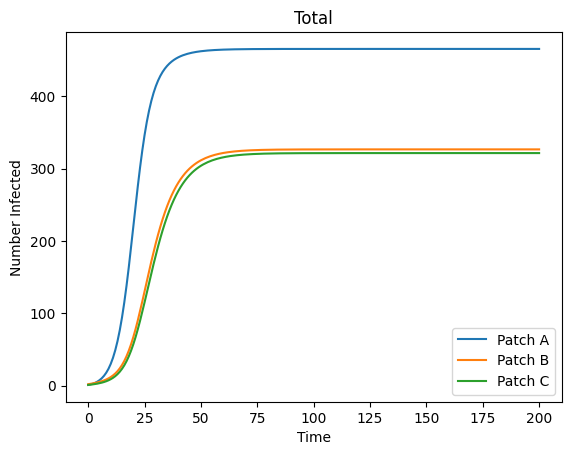

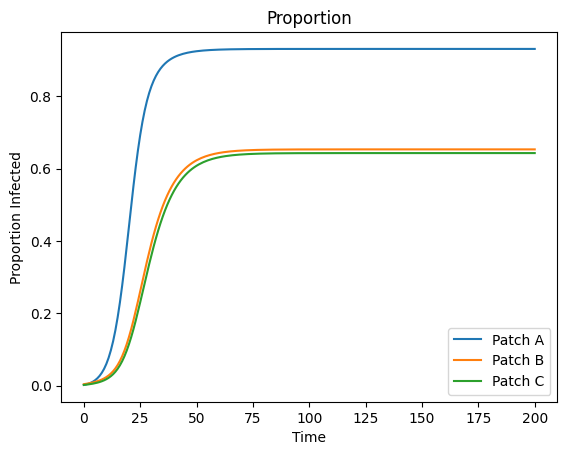


-------------------------------------


-------------------------------------

Original full_sparse_isolate time: 0.000745 seconds
Optimized full_sparse_isolate_fast time: 0.000290 seconds
True
[[250.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [143.75         0.625        0.           0.625        5.
    0.           0.           0.           0.        ]
 [ 94.16666667   0.41666667   0.           0.41666667   0.
    0.83333333   0.           0.83333333   3.33333333]
 [  2.5          0.3125       0.           0.3125      71.875
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         300.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          62.5
   10.41666667   0.          10.41666667  41.66666667]
 [  1.66666667   0.20833333   0.           0.20833333   0.
    0.41666667   0.           0.41666667  47.08333333]
 [ 

In [ ]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T

p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1



def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

plt.plot(t, output[0], label='Patch A')
plt.plot(t, output[4], label='Patch B')
plt.plot(t, output[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Number Infected")
plt.title("Total")
plt.show()

plt.plot(t, output[0]/pop_vector[0], label='Patch A')
plt.plot(t, output[4]/pop_vector[4], label='Patch B')
plt.plot(t, output[8]/pop_vector[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Proportion")
plt.show()

print("\n-------------------------------------\n")
print("\n-------------------------------------\n")


list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [0]

import time

# --- Timing the original function ---
start = time.time()
original = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)
time_full = time.time() - start
print(f"Original full_sparse_isolate time: {time_full:.6f} seconds")


# --- Timing the fast function ---
start = time.time()
# Preconvert
# Call the final fast function
faster = full_sparse_isolate_ultrafast_csr(
    sparse_expanded_p_matrix,
    patch_station_names,
    station_to_rows,
    row_home_patches,
    modification=0.9
)
time_fast = time.time() - start
print(f"Optimized full_sparse_isolate_fast time: {time_fast:.6f} seconds")
print(np.allclose(original.toarray(), faster.toarray()))
print(original.toarray(),"\n\n\n",faster.toarray())


[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 11453.59it/s]


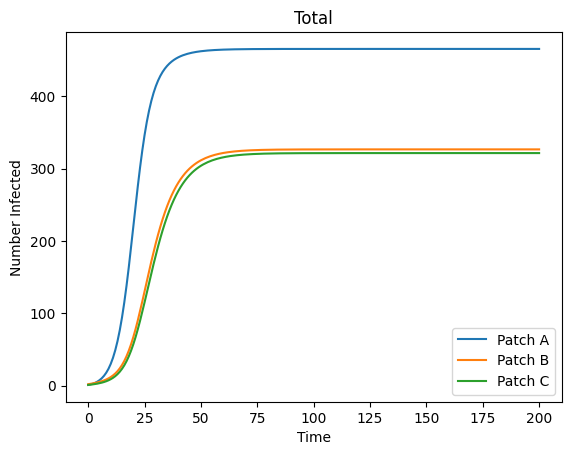

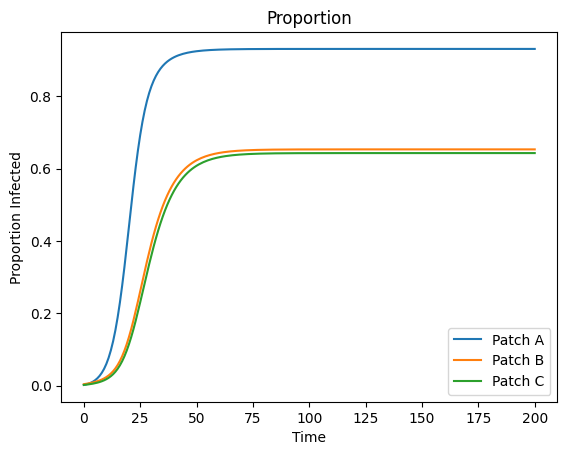


-------------------------------------


-------------------------------------



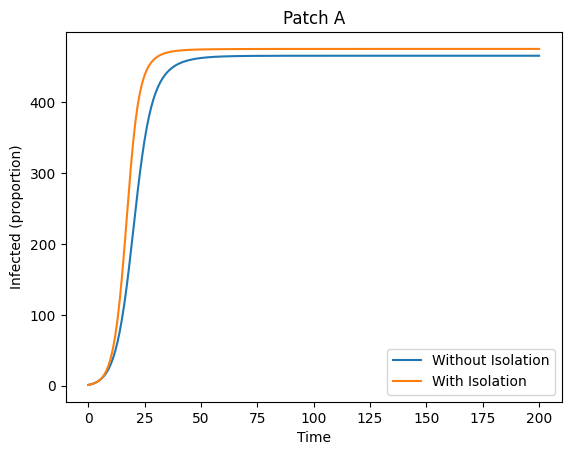

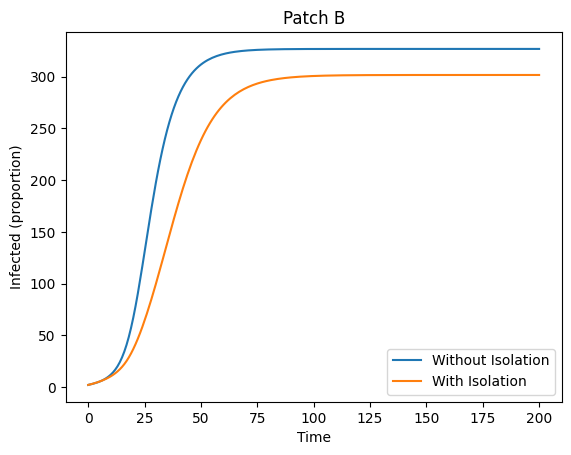

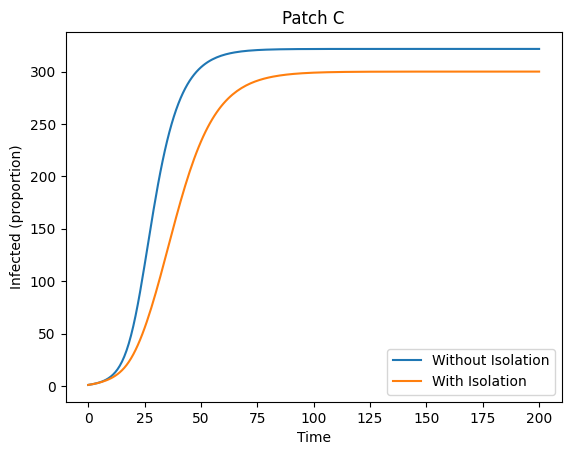

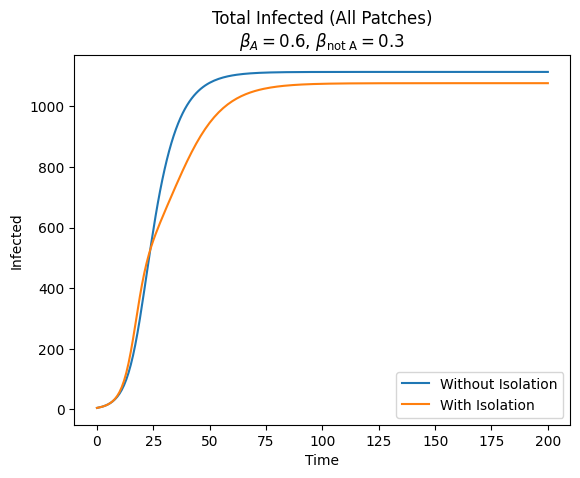

Total infections prevented by isolating ['A']: 37.19085670458958

Finished all runs.


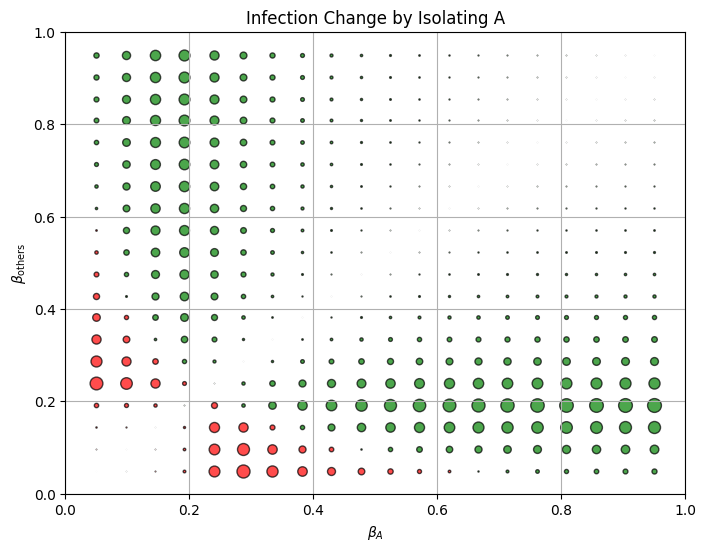

In [ ]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1



def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

plt.plot(t, output[0], label='Patch A')
plt.plot(t, output[4], label='Patch B')
plt.plot(t, output[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Number Infected")
plt.title("Total")
plt.show()

plt.plot(t, output[0]/pop_vector[0], label='Patch A')
plt.plot(t, output[4]/pop_vector[4], label='Patch B')
plt.plot(t, output[8]/pop_vector[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Proportion")
plt.show()

print("\n-------------------------------------\n")
print("\n-------------------------------------\n")


list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [0]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)

labels = ['Without Isolation', 'With Isolation']

# A, B, C plots
for i, patch_label in zip(range(3), ['Patch A', 'Patch B', 'Patch C']):
    plt.figure()
    for r, sim_label in zip(results, labels):
        plt.plot(t, r[i], label=sim_label)
    plt.title(patch_label)
    plt.xlabel("Time")
    plt.ylabel("Infected (proportion)")
    plt.legend()
    plt.show()

# Total plot
plt.figure()
for total, sim_label in zip(totals, labels):
    plt.plot(t, total, label=sim_label)
plt.title(f"Total Infected (All Patches)\n$\\beta_A = {beta[0]}$, $\\beta_{{\\mathrm{{not\\ A}}}} = {beta[1]}$")
plt.xlabel("Time")
plt.ylabel("Infected")
plt.legend()
plt.show()
print(f"Total infections prevented by isolating {np.array(station_list)[patches_to_isolate]}:",totals[0][-1]-totals[1][-1])


beta_A_vals = np.linspace(0.05, 0.95, 20)
beta_others_vals = np.linspace(0.05, 0.95, 20)

X, Y, sizes, colors = [], [], [], []

for beta_A in beta_A_vals:
    for beta_others in beta_others_vals:
        beta = np.array([beta_A] + [beta_others]*8)

        I0_current = np.array([1,0,0,0,2,0,0,0,1])
        S0_current = pop_vector - I0_current
        I_total_0_current = I0_current.copy()

        totals = []
        for p_mat in list_of_p_matrices:
            Nj = pop_vector @ p_mat
            Nj[Nj == 0] = 1

            output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, timesteps))
            total_infected = output.sum(axis=0)
            totals.append(total_infected)

        infections_prevented = totals[0][-1] - totals[1][-1]

        X.append(beta_A)
        Y.append(beta_others)
        sizes.append(abs(infections_prevented) * 0.5)
        colors.append('red' if infections_prevented < 0 else 'green')

print("\nFinished all runs.")

plt.figure(figsize=(8,6))
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating A')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


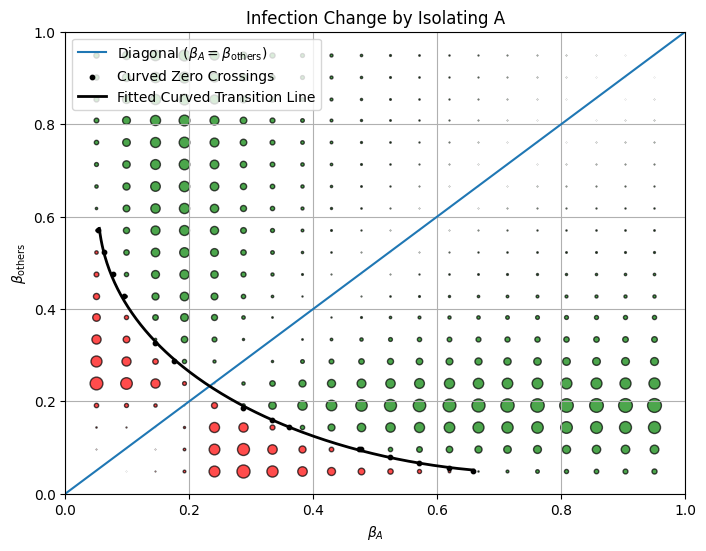

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Assume X, Y, sizes, colors, pop_vector, list_of_p_matrices, gamma, run_model() already available

# 1. Recompute infections_prevented_list
infections_prevented_list = []

for beta_A, beta_others in zip(X, Y):
    beta = np.array([beta_A] + [beta_others]*8)

    I0_current = np.array([1,0,0,0,2,0,0,0,1])
    S0_current = pop_vector - I0_current
    I_total_0_current = I0_current.copy()

    totals = []
    for p_mat in list_of_p_matrices:
        Nj = pop_vector @ p_mat
        Nj[Nj == 0] = 1

        output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, 200))
        total_infected = output.sum(axis=0)
        totals.append(total_infected)

    infections_prevented = totals[0][-1] - totals[1][-1]
    infections_prevented_list.append(infections_prevented)

infections_prevented_list = np.array(infections_prevented_list)

# 2. Organize into grid for neighbor checking
beta_A_unique = np.unique(np.round(X, 4))
beta_others_unique = np.unique(np.round(Y, 4))

bubble_dict = {}
for i in range(len(X)):
    bubble_dict[(np.round(X[i],4), np.round(Y[i],4))] = infections_prevented_list[i]

transition_points = []

# 3. Walk grid to find zero crossings
for beta_A in beta_A_unique:
    for beta_others in beta_others_unique:
        key = (np.round(beta_A,4), np.round(beta_others,4))
        if key not in bubble_dict:
            continue

        # Right neighbor
        right_key = (np.round(beta_A+(beta_A_unique[1]-beta_A_unique[0]),4), np.round(beta_others,4))
        if right_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[right_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A*(1-w) + right_key[0]*w
                y_zero = beta_others
                transition_points.append((x_zero, y_zero))

        # Up neighbor
        up_key = (np.round(beta_A,4), np.round(beta_others+(beta_others_unique[1]-beta_others_unique[0]),4))
        if up_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[up_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A
                y_zero = beta_others*(1-w) + up_key[1]*w
                transition_points.append((x_zero, y_zero))

transition_points = np.array(transition_points)

# 4. Separate diagonal points from curved points
diag_thresh = 0.05  # threshold: how close to diagonal (beta_A ≈ beta_others)
diag_points = []
curve_points = []

for pt in transition_points:
    beta_A, beta_others = pt
    if abs(beta_A - beta_others) < diag_thresh:
        diag_points.append(pt)
    else:
        curve_points.append(pt)

diag_points = np.array(diag_points)
curve_points = np.array(curve_points)

# 5. Fit spline ONLY to curved points
if len(curve_points) > 0:
    sorted_idx = np.argsort(curve_points[:,0])
    curve_points = curve_points[sorted_idx]

    tck, u = splprep([curve_points[:,0], curve_points[:,1]], s=0.02)  # Smooth
    unew = np.linspace(0,1,300)
    out = splev(unew, tck)

# 6. Plot everything
plt.figure(figsize=(8,6))

# Bubbles
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')

# Plot diagonal reference line
diag_line = np.linspace(0, 1, 100)
plt.plot(diag_line, diag_line, '-', label=r'Diagonal ($\beta_A = \beta_{\mathrm{others}}$)')

# Curved zero-crossing points
if len(curve_points) > 0:
    plt.scatter(curve_points[:,0], curve_points[:,1], c='k', s=10, label='Curved Zero Crossings')

# Fitted spline for curve
if len(curve_points) > 0:
    plt.plot(out[0], out[1], 'k-', linewidth=2, label='Fitted Curved Transition Line')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating A')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()


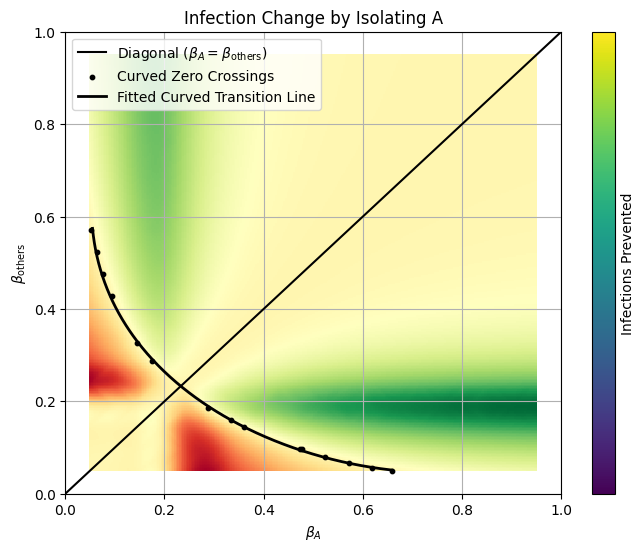

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Assume X, Y, sizes, colors, pop_vector, list_of_p_matrices, gamma, run_model() already available

# 1. Recompute infections_prevented_list
infections_prevented_list = []

for beta_A, beta_others in zip(X, Y):
    beta = np.array([beta_A] + [beta_others]*8)

    I0_current = np.array([1,0,0,0,2,0,0,0,1])
    S0_current = pop_vector - I0_current
    I_total_0_current = I0_current.copy()

    totals = []
    for p_mat in list_of_p_matrices:
        Nj = pop_vector @ p_mat
        Nj[Nj == 0] = 1

        output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, 200))
        total_infected = output.sum(axis=0)
        totals.append(total_infected)

    infections_prevented = totals[0][-1] - totals[1][-1]
    infections_prevented_list.append(infections_prevented)

infections_prevented_list = np.array(infections_prevented_list)

# 2. Organize into grid for neighbor checking
beta_A_unique = np.unique(np.round(X, 4))
beta_others_unique = np.unique(np.round(Y, 4))

bubble_dict = {}
for i in range(len(X)):
    bubble_dict[(np.round(X[i],4), np.round(Y[i],4))] = infections_prevented_list[i]

transition_points = []

# 3. Walk grid to find zero crossings
for beta_A in beta_A_unique:
    for beta_others in beta_others_unique:
        key = (np.round(beta_A,4), np.round(beta_others,4))
        if key not in bubble_dict:
            continue

        # Right neighbor
        right_key = (np.round(beta_A+(beta_A_unique[1]-beta_A_unique[0]),4), np.round(beta_others,4))
        if right_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[right_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A*(1-w) + right_key[0]*w
                y_zero = beta_others
                transition_points.append((x_zero, y_zero))

        # Up neighbor
        up_key = (np.round(beta_A,4), np.round(beta_others+(beta_others_unique[1]-beta_others_unique[0]),4))
        if up_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[up_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A
                y_zero = beta_others*(1-w) + up_key[1]*w
                transition_points.append((x_zero, y_zero))

transition_points = np.array(transition_points)

# 4. Separate diagonal points from curved points
diag_thresh = 0.05  # threshold: how close to diagonal (beta_A ≈ beta_others)
diag_points = []
curve_points = []

for pt in transition_points:
    beta_A, beta_others = pt
    if abs(beta_A - beta_others) < diag_thresh:
        diag_points.append(pt)
    else:
        curve_points.append(pt)

diag_points = np.array(diag_points)
curve_points = np.array(curve_points)

# 5. Fit spline ONLY to curved points
if len(curve_points) > 0:
    sorted_idx = np.argsort(curve_points[:,0])
    curve_points = curve_points[sorted_idx]

    tck, u = splprep([curve_points[:,0], curve_points[:,1]], s=0.02)  # Smooth
    unew = np.linspace(0,1,300)
    out = splev(unew, tck)

# 6. Prepare grid for background coloring
from scipy.interpolate import griddata

plt.figure(figsize=(8,6))

# Create grid
xi = np.linspace(0, 1, 300)
yi = np.linspace(0, 1, 300)
xi, yi = np.meshgrid(xi, yi)

# Interpolate infections_prevented_list onto the grid
zi = griddata((X, Y), infections_prevented_list, (xi, yi), method='cubic')

# Plot the gradient background
plt.pcolormesh(xi, yi, zi, shading='auto', cmap='RdYlGn', vmin=np.min(infections_prevented_list), vmax=np.max(infections_prevented_list))

# Plot diagonal reference line
diag_line = np.linspace(0, 1, 100)
plt.plot(diag_line, diag_line, '-', color='black', label=r'Diagonal ($\beta_A = \beta_{\mathrm{others}}$)')

# Curved zero-crossing points
if len(curve_points) > 0:
    plt.scatter(curve_points[:,0], curve_points[:,1], c='k', s=10, label='Curved Zero Crossings')

# Fitted spline for curve
if len(curve_points) > 0:
    plt.plot(out[0], out[1], 'k-', linewidth=2, label='Fitted Curved Transition Line')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating A')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
cbar = plt.colorbar(label='Infections Prevented')
cbar.set_ticks([])          # Remove ticks
cbar.ax.set_yticklabels([]) # Remove number labels
plt.legend()
plt.show()



[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5632.96it/s]


-------------------------------------


-------------------------------------




Finished all runs.


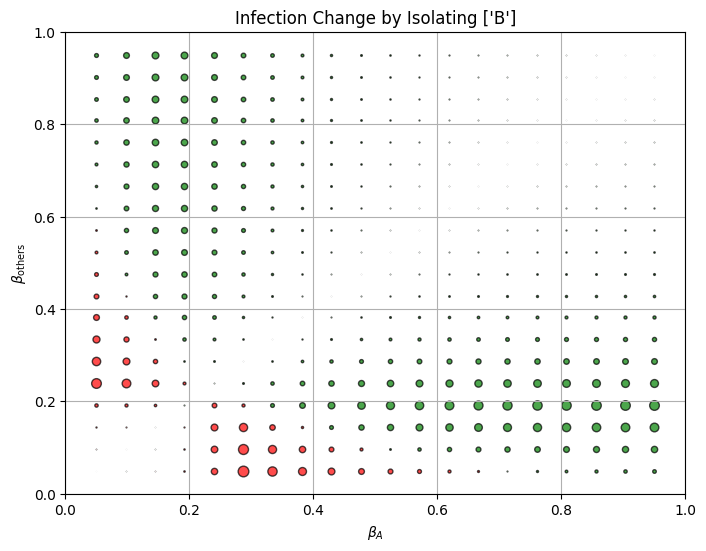

In [ ]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1



def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [1]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)


beta_A_vals = np.linspace(0.05, 0.95, 20)
beta_others_vals = np.linspace(0.05, 0.95, 20)

X, Y, sizes, colors = [], [], [], []

for beta_A in beta_A_vals:
    for beta_others in beta_others_vals:
        beta = np.array([beta_A] + [beta_others]*8)

        I0_current = np.array([1,0,0,0,2,0,0,0,1])
        S0_current = pop_vector - I0_current
        I_total_0_current = I0_current.copy()

        totals = []
        for p_mat in list_of_p_matrices:
            Nj = pop_vector @ p_mat
            Nj[Nj == 0] = 1

            output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, timesteps))
            total_infected = output.sum(axis=0)
            totals.append(total_infected)

        infections_prevented = totals[0][-1] - totals[1][-1]

        X.append(beta_A)
        Y.append(beta_others)
        sizes.append(abs(infections_prevented) * 0.5)
        colors.append('red' if infections_prevented < 0 else 'green')

print("\nFinished all runs.")

plt.figure(figsize=(8,6))
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title(f'Infection Change by Isolating {np.array(station_list)[patches_to_isolate]}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5511.57it/s]



Finished all runs.


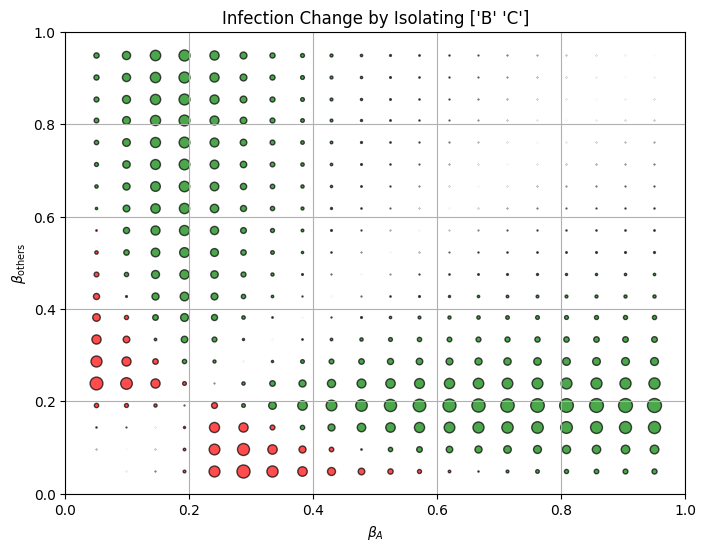

In [ ]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1



def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [1,2]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)


beta_A_vals = np.linspace(0.05, 0.95, 20)
beta_others_vals = np.linspace(0.05, 0.95, 20)

X, Y, sizes, colors = [], [], [], []

for beta_A in beta_A_vals:
    for beta_others in beta_others_vals:
        beta = np.array([beta_A] + [beta_others]*8)

        I0_current = np.array([1,0,0,0,2,0,0,0,1])
        S0_current = pop_vector - I0_current
        I_total_0_current = I0_current.copy()

        totals = []
        for p_mat in list_of_p_matrices:
            Nj = pop_vector @ p_mat
            Nj[Nj == 0] = 1

            output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, timesteps))
            total_infected = output.sum(axis=0)
            totals.append(total_infected)

        infections_prevented = totals[0][-1] - totals[1][-1]

        X.append(beta_A)
        Y.append(beta_others)
        sizes.append(abs(infections_prevented) * 0.5)
        colors.append('red' if infections_prevented < 0 else 'green')

print("\nFinished all runs.")

plt.figure(figsize=(8,6))
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title(f'Infection Change by Isolating {np.array(station_list)[patches_to_isolate]}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


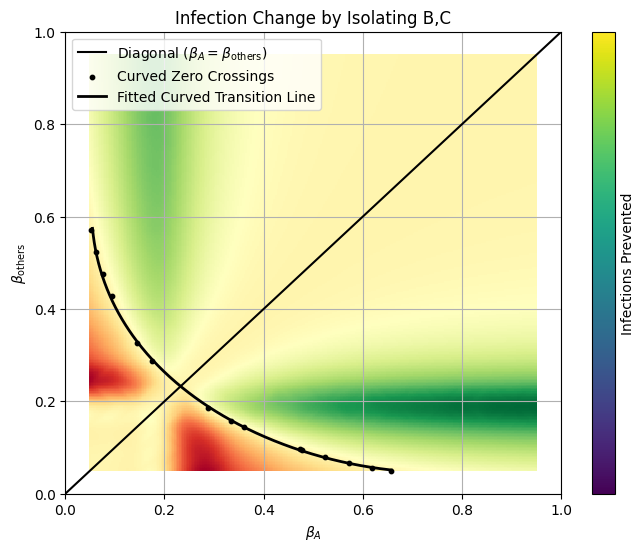

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Assume X, Y, sizes, colors, pop_vector, list_of_p_matrices, gamma, run_model() already available

# 1. Recompute infections_prevented_list
infections_prevented_list = []

for beta_A, beta_others in zip(X, Y):
    beta = np.array([beta_A] + [beta_others]*8)

    I0_current = np.array([1,0,0,0,2,0,0,0,1])
    S0_current = pop_vector - I0_current
    I_total_0_current = I0_current.copy()

    totals = []
    for p_mat in list_of_p_matrices:
        Nj = pop_vector @ p_mat
        Nj[Nj == 0] = 1

        output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, 200))
        total_infected = output.sum(axis=0)
        totals.append(total_infected)

    infections_prevented = totals[0][-1] - totals[1][-1]
    infections_prevented_list.append(infections_prevented)

infections_prevented_list = np.array(infections_prevented_list)

# 2. Organize into grid for neighbor checking
beta_A_unique = np.unique(np.round(X, 4))
beta_others_unique = np.unique(np.round(Y, 4))

bubble_dict = {}
for i in range(len(X)):
    bubble_dict[(np.round(X[i],4), np.round(Y[i],4))] = infections_prevented_list[i]

transition_points = []

# 3. Walk grid to find zero crossings
for beta_A in beta_A_unique:
    for beta_others in beta_others_unique:
        key = (np.round(beta_A,4), np.round(beta_others,4))
        if key not in bubble_dict:
            continue

        # Right neighbor
        right_key = (np.round(beta_A+(beta_A_unique[1]-beta_A_unique[0]),4), np.round(beta_others,4))
        if right_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[right_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A*(1-w) + right_key[0]*w
                y_zero = beta_others
                transition_points.append((x_zero, y_zero))

        # Up neighbor
        up_key = (np.round(beta_A,4), np.round(beta_others+(beta_others_unique[1]-beta_others_unique[0]),4))
        if up_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[up_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A
                y_zero = beta_others*(1-w) + up_key[1]*w
                transition_points.append((x_zero, y_zero))

transition_points = np.array(transition_points)

# 4. Separate diagonal points from curved points
diag_thresh = 0.05  # threshold: how close to diagonal (beta_A ≈ beta_others)
diag_points = []
curve_points = []

for pt in transition_points:
    beta_A, beta_others = pt
    if abs(beta_A - beta_others) < diag_thresh:
        diag_points.append(pt)
    else:
        curve_points.append(pt)

diag_points = np.array(diag_points)
curve_points = np.array(curve_points)

# 5. Fit spline ONLY to curved points
if len(curve_points) > 0:
    sorted_idx = np.argsort(curve_points[:,0])
    curve_points = curve_points[sorted_idx]

    tck, u = splprep([curve_points[:,0], curve_points[:,1]], s=0.02)  # Smooth
    unew = np.linspace(0,1,300)
    out = splev(unew, tck)

# 6. Prepare grid for background coloring
from scipy.interpolate import griddata

plt.figure(figsize=(8,6))

# Create grid
xi = np.linspace(0, 1, 300)
yi = np.linspace(0, 1, 300)
xi, yi = np.meshgrid(xi, yi)

# Interpolate infections_prevented_list onto the grid
zi = griddata((X, Y), infections_prevented_list, (xi, yi), method='cubic')

# Plot the gradient background
plt.pcolormesh(xi, yi, zi, shading='auto', cmap='RdYlGn', vmin=np.min(infections_prevented_list), vmax=np.max(infections_prevented_list))

# Plot diagonal reference line
diag_line = np.linspace(0, 1, 100)
plt.plot(diag_line, diag_line, '-', color='black', label=r'Diagonal ($\beta_A = \beta_{\mathrm{others}}$)')

# Curved zero-crossing points
if len(curve_points) > 0:
    plt.scatter(curve_points[:,0], curve_points[:,1], c='k', s=10, label='Curved Zero Crossings')

# Fitted spline for curve
if len(curve_points) > 0:
    plt.plot(out[0], out[1], 'k-', linewidth=2, label='Fitted Curved Transition Line')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating B,C')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
cbar = plt.colorbar(label='Infections Prevented')
cbar.set_ticks([])          # Remove ticks
cbar.ax.set_yticklabels([]) # Remove number labels
plt.legend()
plt.show()


[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5869.44it/s]


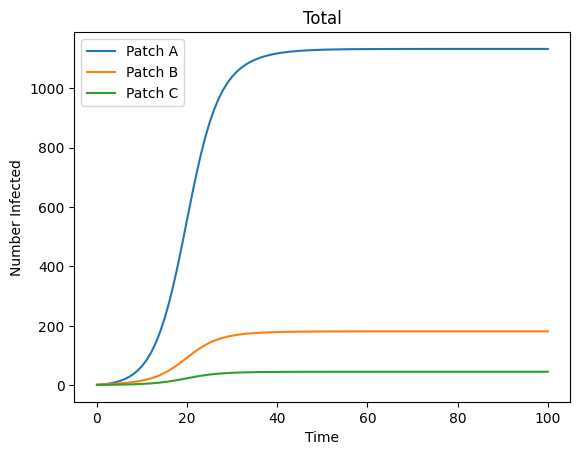

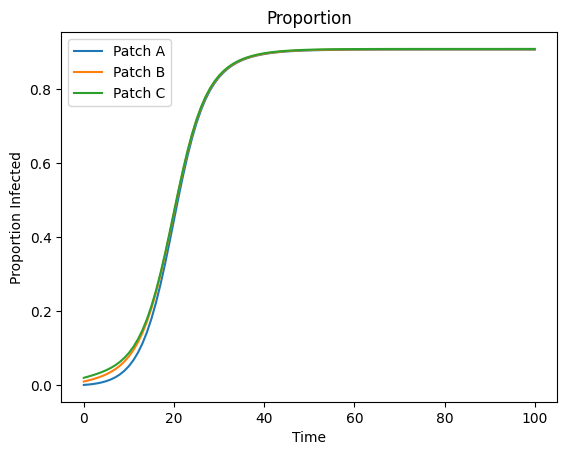


-------------------------------------


-------------------------------------



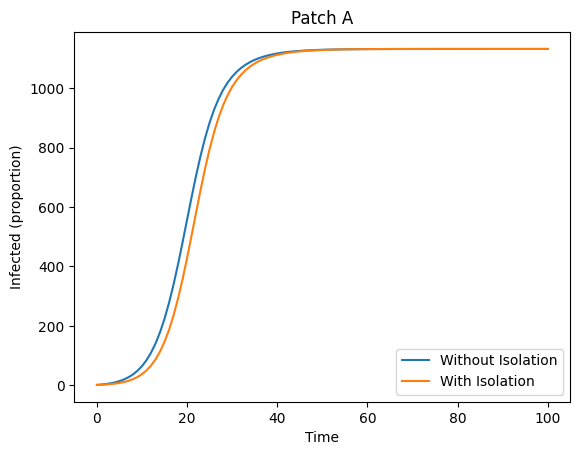

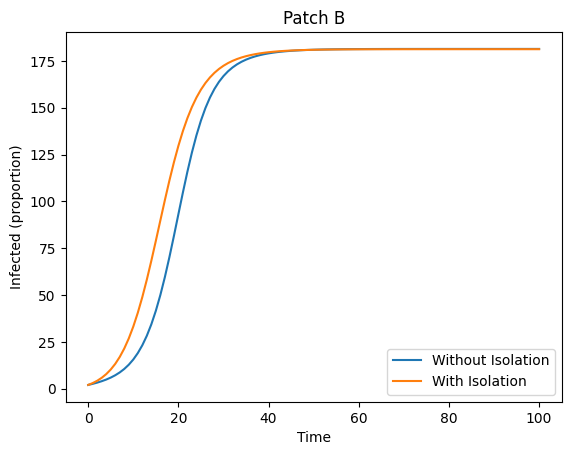

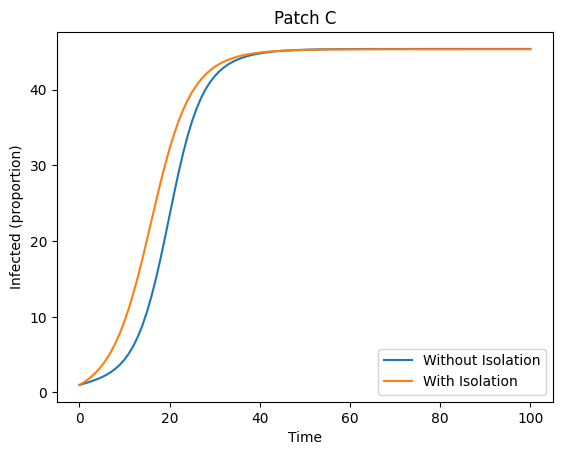

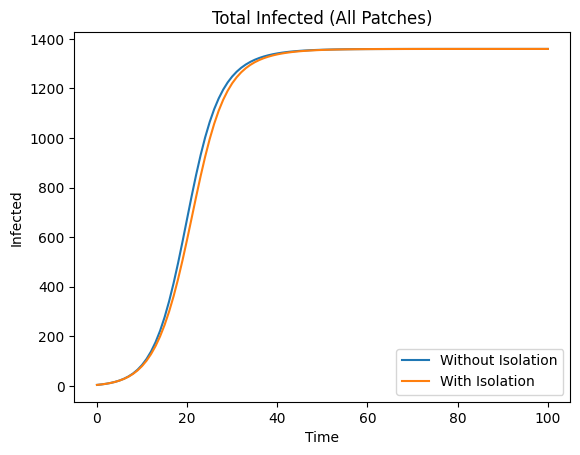

Total infections prevented by isolating ['A']: 0.07328978215764437


In [ ]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

N = [1250,200,50]
# N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()




def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1



def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.5
beta = np.array([everyone_else, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 100

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

plt.plot(t, output[0], label='Patch A')
plt.plot(t, output[4], label='Patch B')
plt.plot(t, output[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Number Infected")
plt.title("Total")
plt.show()

plt.plot(t, output[0]/pop_vector[0], label='Patch A')
plt.plot(t, output[4]/pop_vector[4], label='Patch B')
plt.plot(t, output[8]/pop_vector[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Proportion")
plt.show()


print("\n-------------------------------------\n")
print("\n-------------------------------------\n")


list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)



patches_to_isolate = [0]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)

labels = ['Without Isolation', 'With Isolation']

# A, B, C plots
for i, patch_label in zip(range(3), ['Patch A', 'Patch B', 'Patch C']):
    plt.figure()
    for r, sim_label in zip(results, labels):
        plt.plot(t, r[i], label=sim_label)
    plt.title(patch_label)
    plt.xlabel("Time")
    plt.ylabel("Infected (proportion)")
    plt.legend()
    plt.show()

# Total plot
plt.figure()
for total, sim_label in zip(totals, labels):
    plt.plot(t, total, label=sim_label)
plt.title("Total Infected (All Patches)")
plt.xlabel("Time")
plt.ylabel("Infected")
plt.legend()
plt.show()
print(f"Total infections prevented by isolating {np.array(station_list)[patches_to_isolate]}:",totals[0][-1]-totals[1][-1])


In [ ]:
for i in range(9):
    print(sparse_expanded_p_matrix.toarray()[i])
    print(isolated[i])
    print("\n")

[300.   0.   0.   0.   0.   0.   0.   0.   0.]
[300.   0.   0.   0.   0.   0.   0.   0.   0.]


[100.   2.   0.   2.  96.   0.   0.   0.   0.]
[190.    0.2   0.    0.2   9.6   0.    0.    0.    0. ]


[60.  2.  0.  2.  0.  3.  0.  3. 30.]
[60.  2.  0.  2.  0.  3.  0.  3. 30.]


[ 96.   2.   0.   2. 100.   0.   0.   0.   0.]
[  9.6   0.2   0.    0.2 190.    0.    0.    0.    0. ]


[  0.   0.   0.   0. 300.   0.   0.   0.   0.]
[  0.   0.   0.   0. 300.   0.   0.   0.   0.]


[  0.   0.   0.   0. 100.   3.   0.   3.  84.]
[  0.    0.    0.    0.  181.    0.3   0.    0.3   8.4]


[30.  2.  0.  2.  0.  3.  0.  3. 60.]
[30.  2.  0.  2.  0.  3.  0.  3. 60.]


[  0.   0.   0.   0.  84.   3.   0.   3. 100.]
[  0.    0.    0.    0.    8.4   0.3   0.    0.3 181. ]


[  0.   0.   0.   0.   0.   0.   0.   0. 300.]
[  0.   0.   0.   0.   0.   0.   0.   0. 300.]




In [ ]:
isolated_p_matrix = convert_back_to_classic_p(isolated)
for i in range(9):
    round_to = 6
    print(np.round(p_matrix[i],round_to))
    print(np.round(isolated_p_matrix[i],round_to))
    print("\n")

[0.766667 0.006667 0.       0.006667 0.16     0.005    0.       0.005
 0.05    ]
[0.916667 0.003667 0.       0.003667 0.016    0.005    0.       0.005
 0.05    ]


[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]


[0.13913  0.002899 0.       0.002899 0.724638 0.004348 0.       0.004348
 0.121739]
[0.013913 0.00029  0.       0.00029  0.972464 0.000435 0.       0.000435
 0.012174]


[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]


[0.050847 0.00339  0.       0.00339  0.142373 0.010169 0.       0.010169
 0.779661]
[0.050847 0.00339  0.       0.00339  0.014237 0.005593 0.       0.005593
 0.916949]




In [ ]:
def modify_p_matrix(p_matrix,percentage):
    modifier = percentage/100
    p_matrix2 = p_matrix.copy()

    for row in range(p_matrix.shape[0]):
        p_matrix2[row][row] += modifier*(np.sum(p_matrix2[row])-p_matrix2[row][row])
        p_matrix2[row] *= 1-modifier
        p_matrix2[row][row] /= (1-modifier)
    return p_matrix2

def modify_p_matrix_sparse(p_matrix, percentage):
    modifier = percentage / 100
    p_matrix2 = p_matrix.tocsr()  # Convert to CSR format for efficient row-wise operations

    row_sums = np.array(p_matrix2.sum(axis=1)).flatten()  # Compute row sums
    diag_values = p_matrix2.diagonal()  # Extract diagonal elements

    # Update diagonal first to match dense implementation
    new_diag_values = diag_values + modifier * (row_sums - diag_values)

    # Scale entire matrix
    p_matrix2 = p_matrix2.multiply(1 - modifier)

    # Correct the diagonal values properly
    p_matrix2.setdiag(new_diag_values)

    return p_matrix2

In [ ]:
timesteps = 100
print(p_matrix.shape)
p_matrix = modify_p_matrix_sparse(sparse_p,5).toarray()
print(p_matrix.shape)

short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = np.zeros(63001)
pop_vector[np.arange(251) * (251 + 1)] = short_pop_vector

I0 = np.zeros(63001)
I0[home_patches] = current_cases
S0 = pop_vector - I0
I_total_0 = cum_cases

gamma = 1/5

params = [S0, I0, I_total_0, beta, gamma, timesteps]
sol = run_model_London(params)

totals = sol[2]
I_span = sol[1]



(63001, 63001)
(63001, 63001)


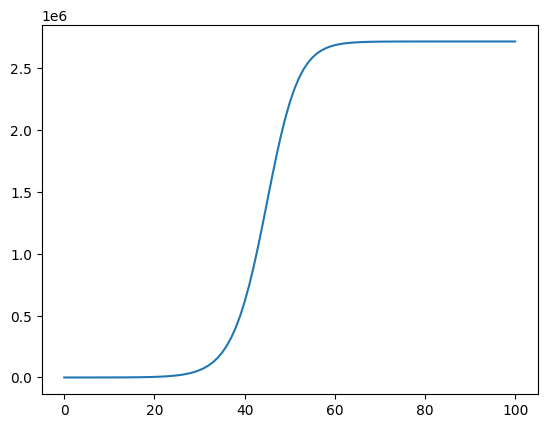

In [ ]:
tspan = np.linspace(0,timesteps,timesteps+1)
plt.plot(tspan,np.sum(I_span,axis=0))


Running simulations: 100%|██████████| 6/6 [01:21<00:00, 13.65s/run]


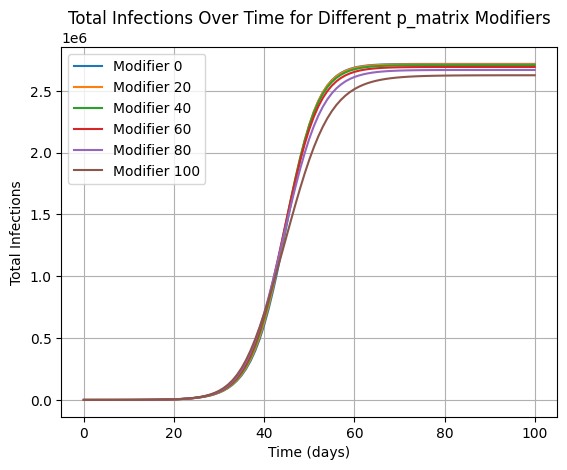

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Define time range
timesteps = 100
tspan = np.linspace(0, timesteps, timesteps+1)

# Initialize storage for results
modifier_values = np.arange(0, 120, 20)  # [0, 5, 10, ..., 50]
infection_sums = []

# Loop over modifier values with progress bar
for modifier in tqdm(modifier_values, desc="Running simulations", unit="run"):
    # Modify p_matrix
    p_matrix = modify_p_matrix_sparse(sparse_p,modifier).toarray()

    # Define initial conditions
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = np.zeros(63001)
    pop_vector[np.arange(251) * (251 + 1)] = short_pop_vector

    I0 = np.zeros(63001)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases

    # Define model parameters
    gamma = 1/5
    params = [S0, I0, I_total_0, beta, gamma, timesteps]

    # Solve the model
    sol = run_model_London(params)

    # Extract the infected subpopulation
    I_span = sol[1]

    # Compute the total number of infections at each timestep
    total_infections = np.sum(I_span, axis=0)

    # Store the result
    infection_sums.append(total_infections)

    # Plot each curve
    plt.plot(tspan, total_infections, label=f"Modifier {modifier}")

# Configure the plot
plt.xlabel("Time (days)")
plt.ylabel("Total Infections")
plt.title("Total Infections Over Time for Different p_matrix Modifiers")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Define time range
timesteps = 150

# Initialize storage for results
modifier_values = np.arange(0, 120, 20)  # [0, 20, 40, ..., 100]
final_infection_counts = []

# Loop over modifier values with progress bar
for modifier in tqdm(modifier_values, desc="Running simulations", unit="run"):
    # Modify p_matrix
    p_matrix = modify_p_matrix_sparse(sparse_p, modifier).toarray()

    # Define initial conditions
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = np.zeros(63001)
    pop_vector[np.arange(251) * (251 + 1)] = short_pop_vector

    I0 = np.zeros(63001)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases

    # Define model parameters
    gamma = 1/5
    params = [S0, I0, I_total_0, beta, gamma, timesteps]

    # Solve the model
    sol = run_model_London(params)

    # Extract the infected subpopulation at the final timestep
    I_span = sol[1]
    final_infections = np.sum(I_span[:, -1])  # Sum over the last timestep

    # Store the result
    final_infection_counts.append(final_infections)


Running simulations: 100%|██████████| 6/6 [01:53<00:00, 18.95s/run]


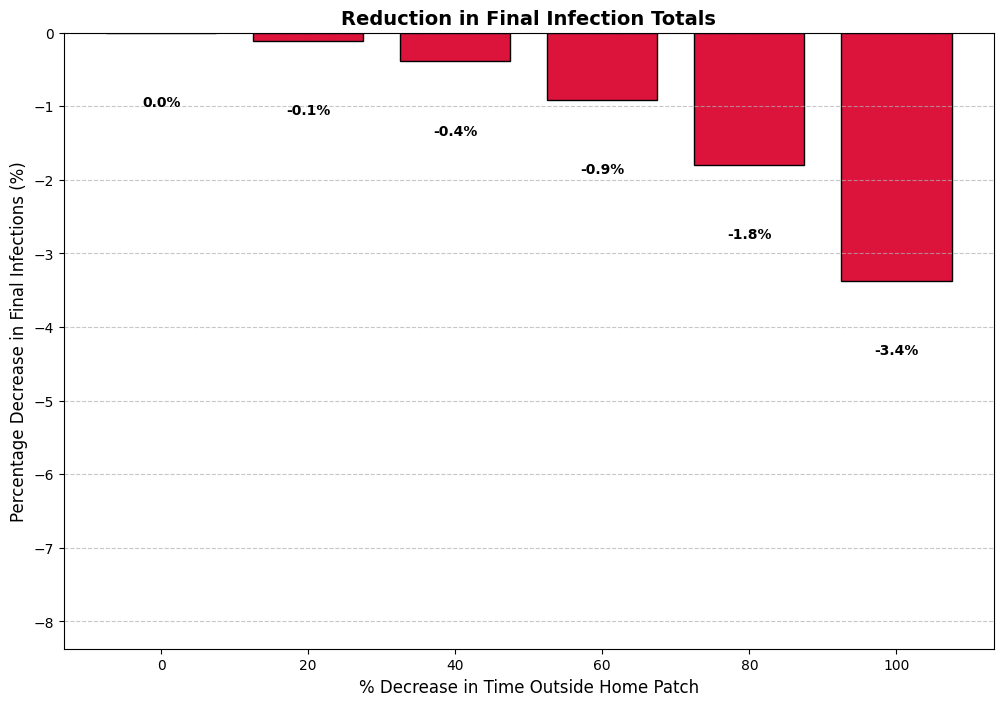

In [ ]:

# Compute percentage decrease from Modifier 0
baseline = final_infection_counts[0]
percentage_decreases = [(count / baseline - 1) * 100 for count in final_infection_counts]  # Negative values

# Plot bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(modifier_values, percentage_decreases, color="crimson", edgecolor="black", width=15)

# Add labels on top of bars (now at the bottom since bars are negative)
for bar, percent in zip(bars, percentage_decreases):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 1,
             f"{percent:.1f}%", ha="center", fontsize=10, fontweight="bold")

# Configure the plot
plt.xlabel("% Decrease in Time Outside Home Patch", fontsize=12)
plt.ylabel("Percentage Decrease in Final Infections (%)", fontsize=12)
plt.title("Reduction in Final Infection Totals", fontsize=14, fontweight="bold")
plt.xticks(modifier_values, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(min(percentage_decreases) - 5, 0)  # Ensure negative direction is clear
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


(77, 63002)
step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75


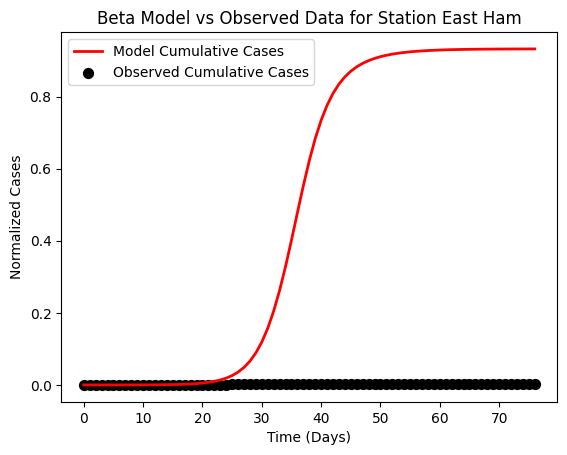

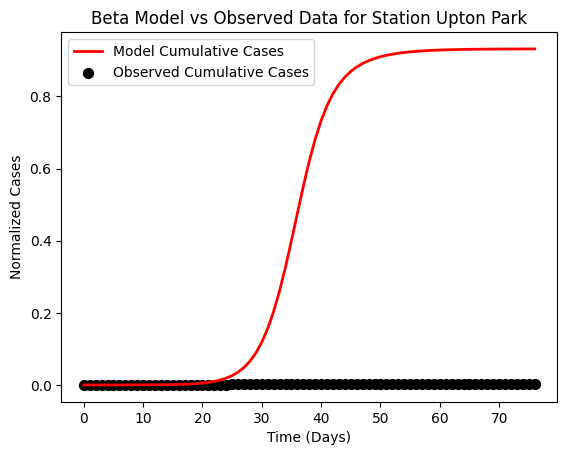

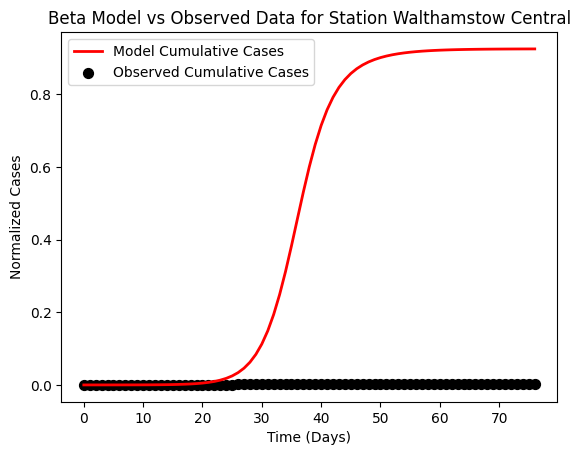

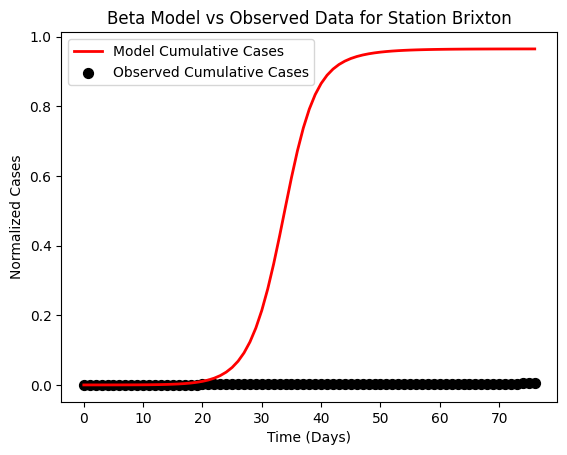

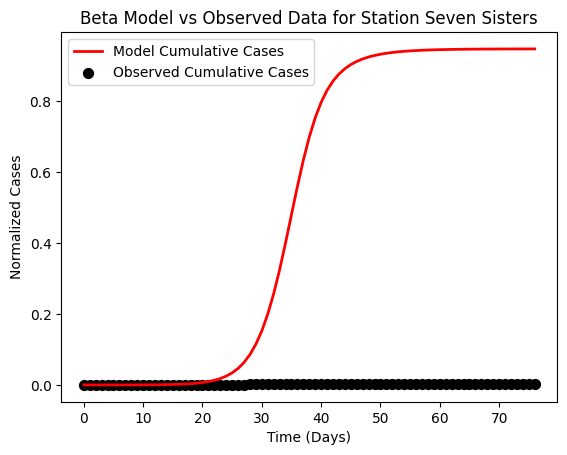

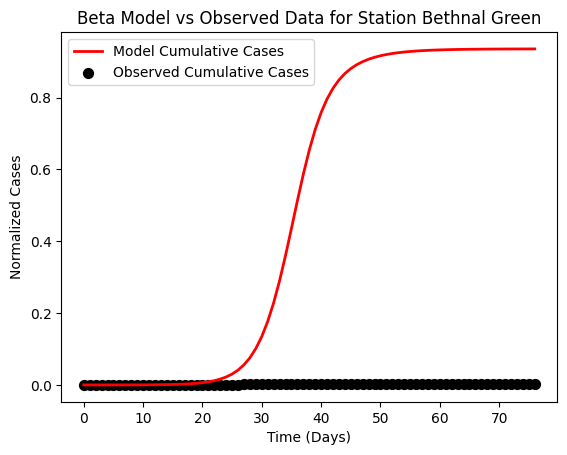

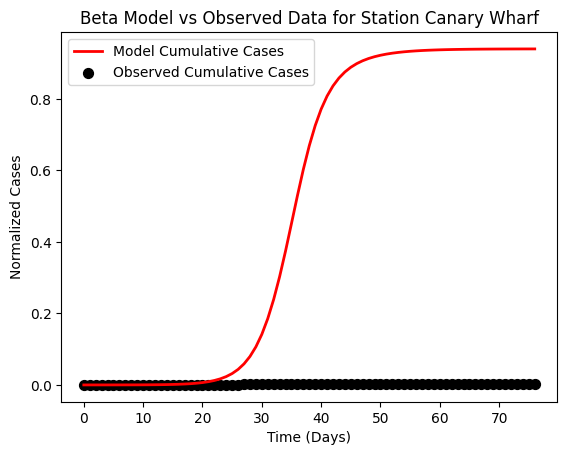

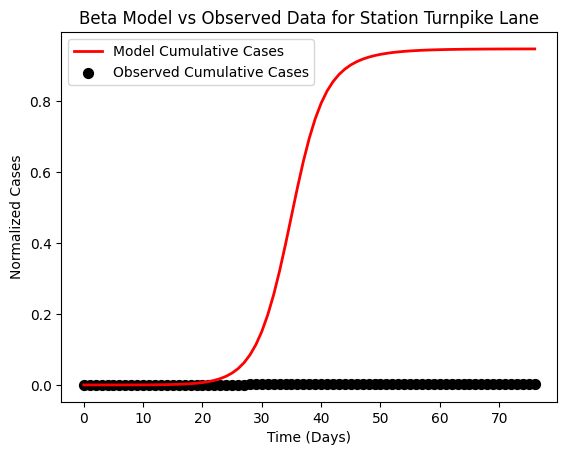

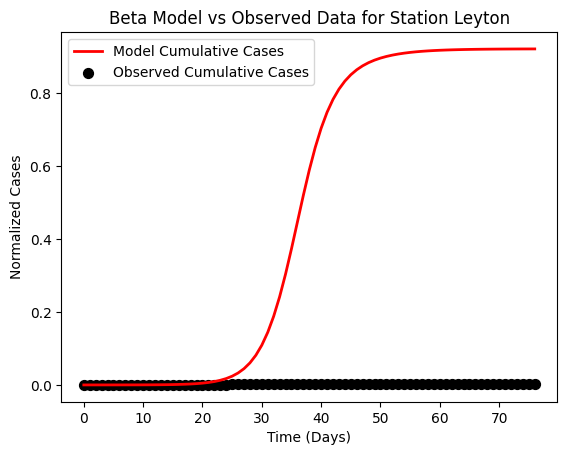

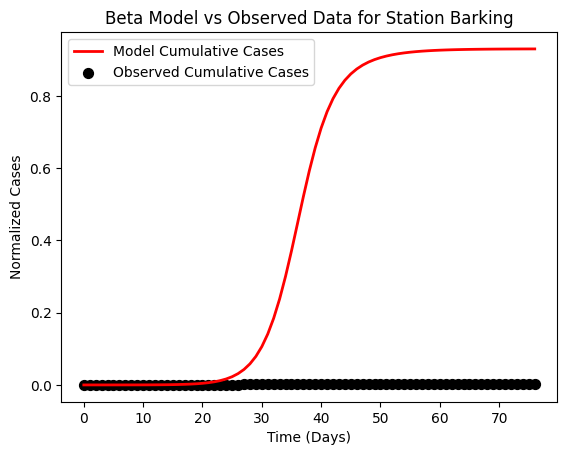

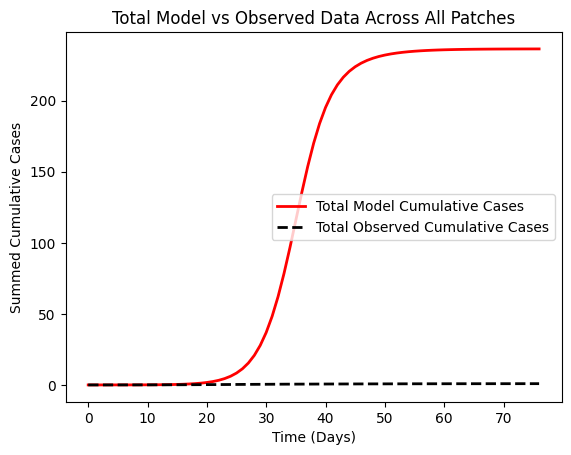


Total Progress:   0%|          | 0/25 [01:37<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import zoom

# Define lighter sampling
num_indices_list = np.linspace(5, 200, 5, dtype=int)  # 5 points
isolation_strength_list = np.linspace(0.1, 1.0, 5)    # 5 points
result_grid = np.zeros((len(isolation_strength_list), len(num_indices_list)))

# Precompute top patch indices
indices_dict = {}
for num_indices in num_indices_list:
    idx = np.argpartition(patch_R0s, -num_indices)[-num_indices:]
    indices_dict[num_indices] = idx[np.argsort(patch_R0s[idx])[::-1]]

# Solve once for base (no isolation) solution
solution_base, params_base = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum_base = solution_base[2][home_patches].sum(axis=0)

total_runs = len(isolation_strength_list) * len(num_indices_list)
pbar = tqdm(total=total_runs, desc="Total Progress")

for i, isolation_strength in enumerate(isolation_strength_list):
    for j, num_indices in enumerate(num_indices_list):
        # Step 1: isolate patches
        indices = indices_dict[num_indices]
        modified_sparse_p = sparse_expanded_p_matrix.copy()
        for patch in indices:
            modified_sparse_p = sparse_isolate_patch(modified_sparse_p, patch, isolation_strength)

        second_p_matrix = convert_back_to_classic_p(modified_sparse_p)
        sparse_second_p = csr_matrix(second_p_matrix)

        # Step 2: run model with isolation
        solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

        # Step 3: calculate final difference
        y2_sum = solution_with_iso[2][home_patches].sum(axis=0)
        final_difference = (y1_sum_base - y2_sum)[-1]

        result_grid[i, j] = final_difference

        pbar.update(1)

pbar.close()

# Smooth interpolation for better visualization
result_grid_smooth = zoom(result_grid, 3, order=3)

# Plot
plt.figure(figsize=(10,8))
plt.imshow(result_grid_smooth, aspect='auto', origin='lower',
           extent=[num_indices_list[0], num_indices_list[-1],
                   isolation_strength_list[0], isolation_strength_list[-1]])
plt.colorbar(label='Final y1_sum - y2_sum')
plt.xlabel('Number of Isolated Patches')
plt.ylabel('Isolation Strength')
plt.title('Impact of Isolation on Final Outcome (Smoothed)')
plt.tight_layout()
plt.show()
